## Predictive Modeling for Occupancy Detection

### Introduction

In this miniproject, I intend to perform supervised machine learning classification on Occupancy Detection dataset from UCI machine learning repository. 

Data Source : https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

Three data sets have been  provided, for training and testing. Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.

The training dataset consists of 5 features variable i.e Temperature, Humidity, Light, CO2, Humidity Ratio and single target variable i.e Occupancy (0 for not occupied rooms and 1 for occupied rooms). Hence, this problem entails a binary classification task with one output variable.

Although there are many statistical learning methods present out there to perform this kind of classification, but my analysis is entirely based on Support Vector Machines. I have also used Recursive Feature Elimination and Random Forest feature importance techniques to make decision on features to be incorporated in the final model.

The following libraries and packges have been used in this miniproject:
* Pandas, Numpy (for data pre-processing).
* Sklearn (for predictive modeling).
* Matplotlib, Seaborn (for Data Visualization).



### Data Pre-processing

In [451]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import datetime
import matplotlib.dates as md
%matplotlib inline
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit,StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score,confusion_matrix
from sklearn.metrics import f1_score,make_scorer, cohen_kappa_score
from sklearn.feature_selection import RFECV,RFE
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier

plt.style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [452]:
# Load the train and test data
filetrain = 'datatraining.txt'
filetest = 'datatest.txt'
filetest2 = 'datatest2.txt'

train = pd.read_csv(filetrain)
test = pd.read_csv(filetest)
test2 = pd.read_csv(filetest2)


How does the data look like? Let's take a look at that....

In [453]:
train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [454]:
# training data info
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
date             8143 non-null object
Temperature      8143 non-null float64
Humidity         8143 non-null float64
Light            8143 non-null float64
CO2              8143 non-null float64
HumidityRatio    8143 non-null float64
Occupancy        8143 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


In [455]:
# testing data info
test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9752 entries, 1 to 9752
Data columns (total 7 columns):
date             9752 non-null object
Temperature      9752 non-null float64
Humidity         9752 non-null float64
Light            9752 non-null float64
CO2              9752 non-null float64
HumidityRatio    9752 non-null float64
Occupancy        9752 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 609.5+ KB


In [456]:
# testing data info
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2665 entries, 140 to 2804
Data columns (total 7 columns):
date             2665 non-null object
Temperature      2665 non-null float64
Humidity         2665 non-null float64
Light            2665 non-null float64
CO2              2665 non-null float64
HumidityRatio    2665 non-null float64
Occupancy        2665 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 166.6+ KB


There are 8143 observations in the training dataset and 9752 & 2665 observations in the two testing datasets respectively. The date column contains the time stamp when the data was collected. Let's go ahead and convert the date column to datetime format and extract year, month, day etc from it...

In [457]:
#Helper function to format Date column
def formatDate(X):
    X["date"] = pd.to_datetime(X["date"])
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["hour"] = X["date"].dt.hour
    X["minute"] = X["date"].dt.minute
    X["second"] = X["date"].dt.second
    X['Weekday']=X[["date"]].apply(lambda z: dt.datetime.strftime(z["date"], '%A'), axis=1)
    return X

# Perform the formating and column extraction on all the datasets.
train=formatDate(train)
test = formatDate(test)
test2 = formatDate(test2)

Let's look at the training data again and check if relevant columns are added....

In [458]:
train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,year,month,day,hour,minute,second,Weekday
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1,2015,2,4,17,51,0,Wednesday
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1,2015,2,4,17,51,59,Wednesday
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1,2015,2,4,17,53,0,Wednesday
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1,2015,2,4,17,54,0,Wednesday
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1,2015,2,4,17,55,0,Wednesday


From the data source it is known that the ground truth occupany was obtained using time stamped pictures that were taken every minute. Let's check out the relative class proportions of the ground truth values in the training and testing datatsets.

In [459]:
1.0*train['Occupancy'].value_counts()/train.shape[0]

0    0.78767
1    0.21233
Name: Occupancy, dtype: float64

In [460]:
1.0*test['Occupancy'].value_counts()/test.shape[0]

0    0.635272
1    0.364728
Name: Occupancy, dtype: float64

In [461]:
1.0*test2['Occupancy'].value_counts()/test2.shape[0]

0    0.789889
1    0.210111
Name: Occupancy, dtype: float64

train and test2 datasets have 21% occupancy. But test dataset shows higher occupany of 36.4%. This information confirms class imbalances in training and both the testing datasets. We will keep this in mind while training the classifier and use relevant metrics for model evaluation.

Before jumping into the machine learning part, let's look at the training data and check out the relationship between occupancy and input feature variables i.e Temperature, Light, CO2, Humidity and HumidityRatio. 

It would be particularly interesting to look at how the input features values change with time and if there is any coherence between change in the input feature values and whether the room was occupied or not. 

### Exploratory Data Analysis

In [462]:
# Helper function for exploratory data analysis
def plot_data(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%A, %b %d'))
    ax.set_xlim([min(x) , max(x)])
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

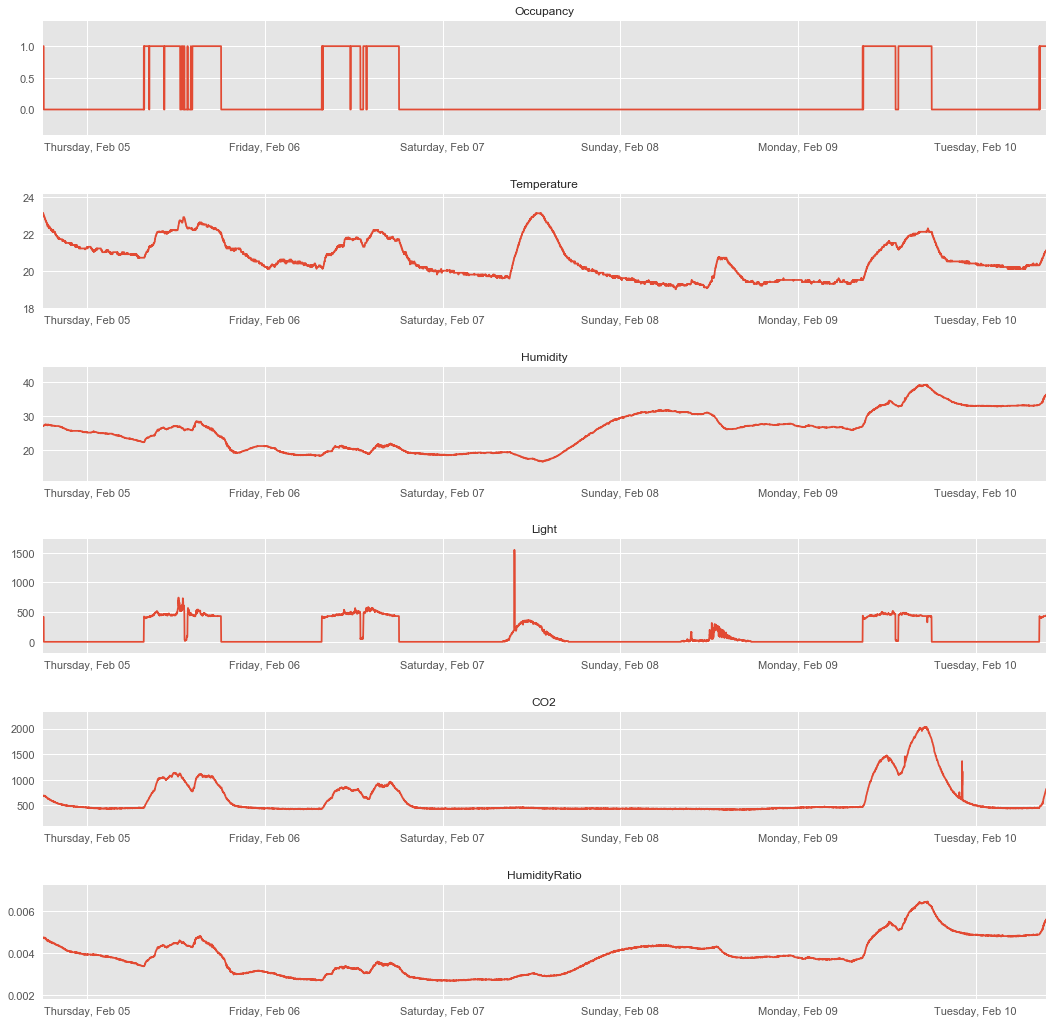

In [463]:
# Plot the training data...
featureCols = train[["Occupancy","Temperature","Humidity","Light","CO2","HumidityRatio"]]

fig, ax = plt.subplots(nrows = len(featureCols.columns.values), figsize=(18, 18))
for i in range(0, len(featureCols.columns.values)):
    plot_data(ax[i],train["date"], 
                featureCols[featureCols.columns.values[i]],featureCols.columns.values[i])
plt.subplots_adjust(hspace=0.5)
plt.show()


Clearly from the above plots, one can observe that change in Light and CO2 is coherent with Occupancy except for some outliers in Light between Feb,07 and Feb,09.
Temperature shows similar variations except for some deviations between Feb,07 and Feb,09. 

Let's find out more about the Occupancy of office rooms per hour per day...

Occupancy on day 4


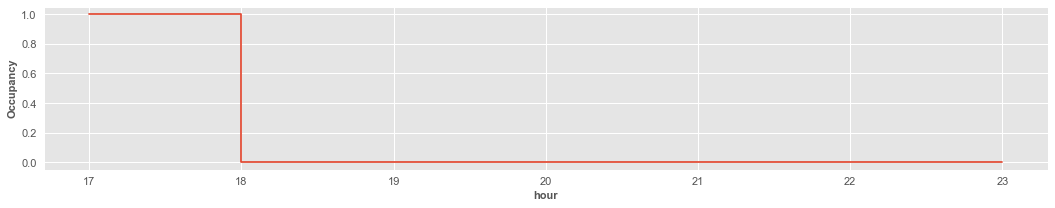

Occupancy on day 5


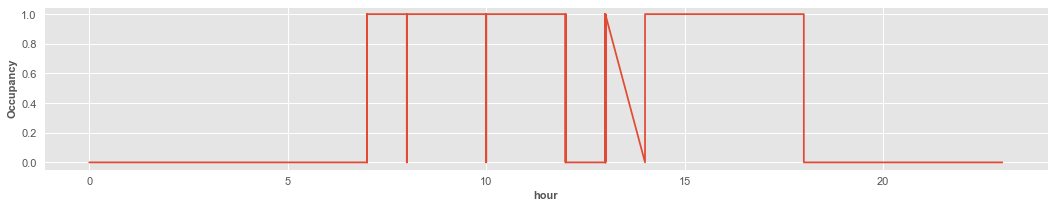

Occupancy on day 6


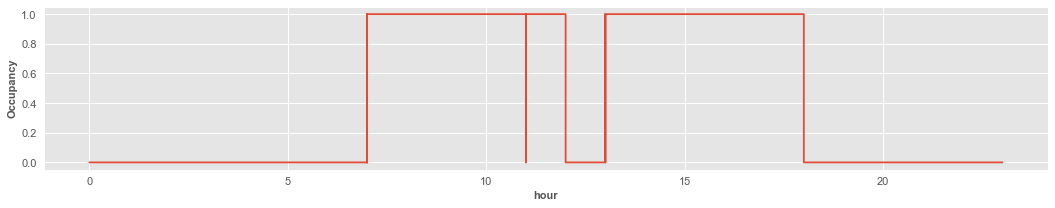

Occupancy on day 7


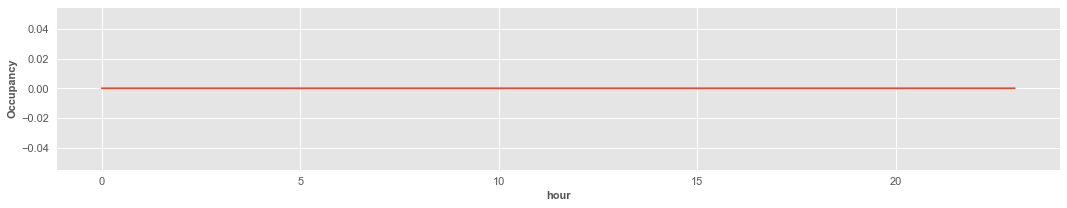

Occupancy on day 8


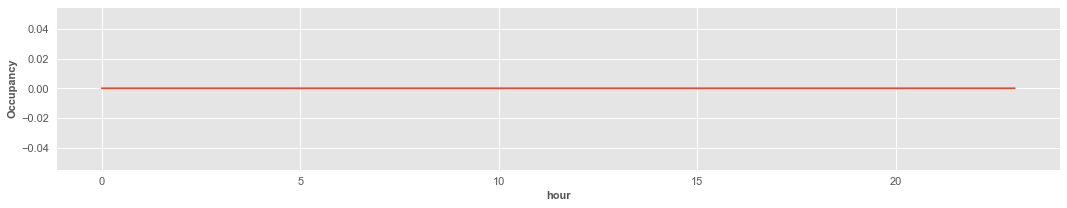

Occupancy on day 9


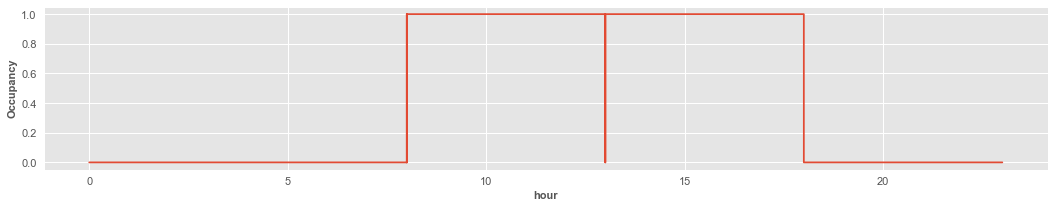

Occupancy on day 10


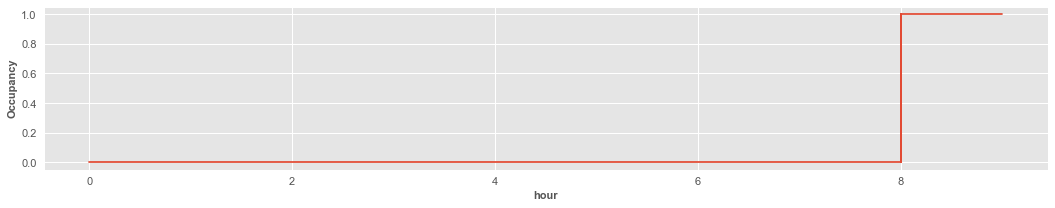

In [486]:
# Plotting occupany per day per hour..
for i in range(len(train['date'].dt.date.unique())):
    df = train[train['date'].dt.date == train['date'].dt.date.unique()[i]]
    print "Occupancy on day {}".format(train['date'].dt.date.unique()[i].day)
    fig, ax = plt.subplots(figsize=(18,3))
    plt.plot(df['hour'],df['Occupancy'])
    plt.xlabel('hour')
    plt.ylabel('Occupancy')
    plt.show()

The office rooms are occupied between 8 am in the morning to 6 pm in the evening. The training data for 4th feb contains occupancy values after 5 pm. And the data for 10th feb is only for couple hours in the morning. Quite intuitive observation!!!

Let's look at the dates when the pictures were taken in testing set1 and testing set2.

In [487]:
print test['date'].dt.date.unique()

[datetime.date(2015, 2, 2) datetime.date(2015, 2, 3)
 datetime.date(2015, 2, 4)]


In [489]:
print test2['date'].dt.date.unique()

[datetime.date(2015, 2, 11) datetime.date(2015, 2, 12)
 datetime.date(2015, 2, 13) datetime.date(2015, 2, 14)
 datetime.date(2015, 2, 15) datetime.date(2015, 2, 16)
 datetime.date(2015, 2, 17) datetime.date(2015, 2, 18)]


Going further let's explore the effect of the input features on Occupancy via Support Vector Machines.

### Predictive Modeling

In [340]:
# Helper function to model the classifier and show training and testing results.
def modelClassifier(data,inputCol1,inputCol2,outputCol,kernel):
    X = data[[inputCol1,inputCol2]].values
    y = data[outputCol].values
    
    # Performing stratifiedshuffle train test split to generate training and validation set.
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    # Standardize the data
    Std = StandardScaler()
    X_train = Std.fit_transform(X_train)
    X_test= Std.transform(X_test)
    
    # Fit the model
    classifier = SVC(kernel=kernel,random_state =0)
    classifier.fit(X_train,y_train)
    
    # Perform predictions using validation set
    y_pred = classifier.predict(X_test)
    
    # evaluate the model
    TN, FP, FN, TP = confusion_matrix(y_test,y_pred).ravel()
    sensitivity = 1.0*TP/(TP + FN)
    specificity = 1.0*TN/(TN + FP)
    
    print "\n Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:\n", np.round(sensitivity*100,2)
    print "\n Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:\n", np.round(specificity*100,2)
    
    # Visualising the Training set results
    fig, ax = plt.subplots(figsize=(25,10))
    X_set, y_set = X_train, y_train
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('black', 'yellow'))(i), label = j)
    plt.title('SVM (Training set)',fontsize=18)
    plt.xlabel(inputCol1,fontsize=18)
    plt.ylabel(inputCol2,fontsize=18)
    plt.legend(fontsize=18)
    plt.show()
    
    # Visualising the Testing set results
    fig, ax = plt.subplots(figsize=(25,10))
    
    X_set, y_set = X_test, y_test
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(('red', 'green')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ListedColormap(('black', 'yellow'))(i), label = j)
    plt.title('SVM (Test set)',fontsize=18)
    plt.xlabel(inputCol1,fontsize=18)
    plt.ylabel(inputCol2,fontsize=18)
    plt.legend()
    plt.show()
    

There are five input features. Let's look at the modeling results using two features at a time with both linear and non linear SVMs...

### Temperature and Light

Classfication results using Temperature and Light features with Linear SVM :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
99.42

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
98.99


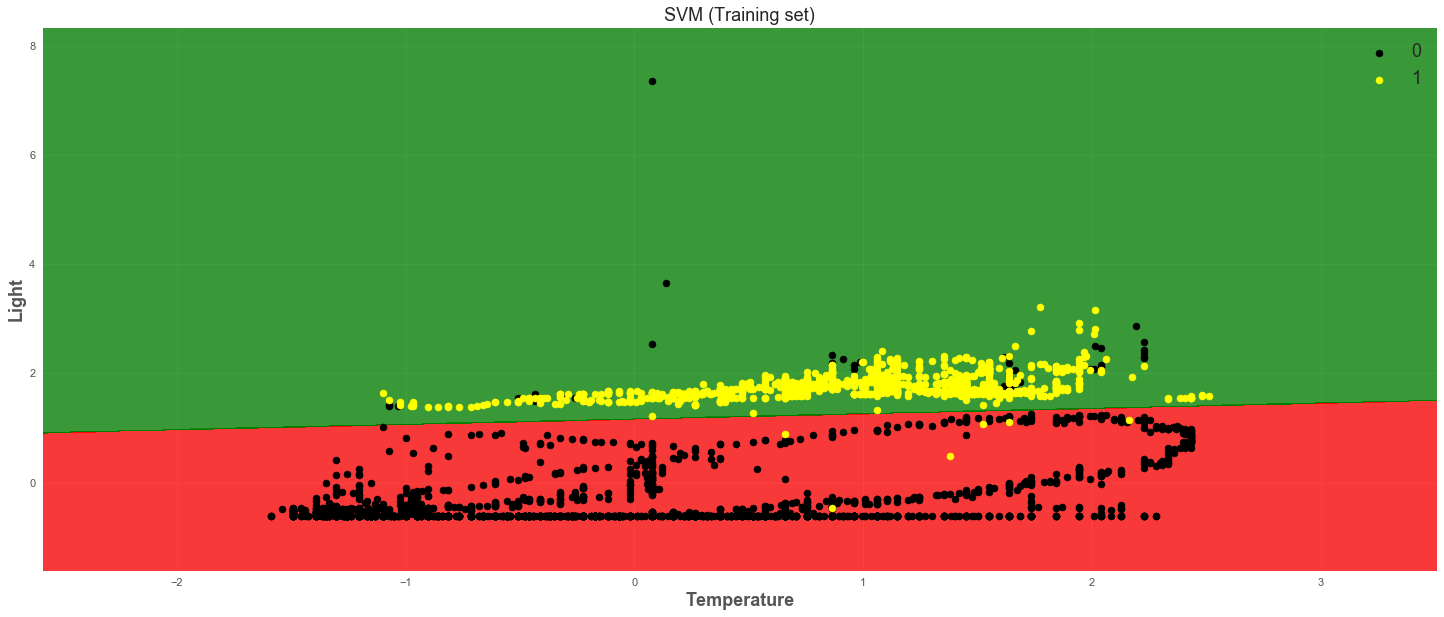

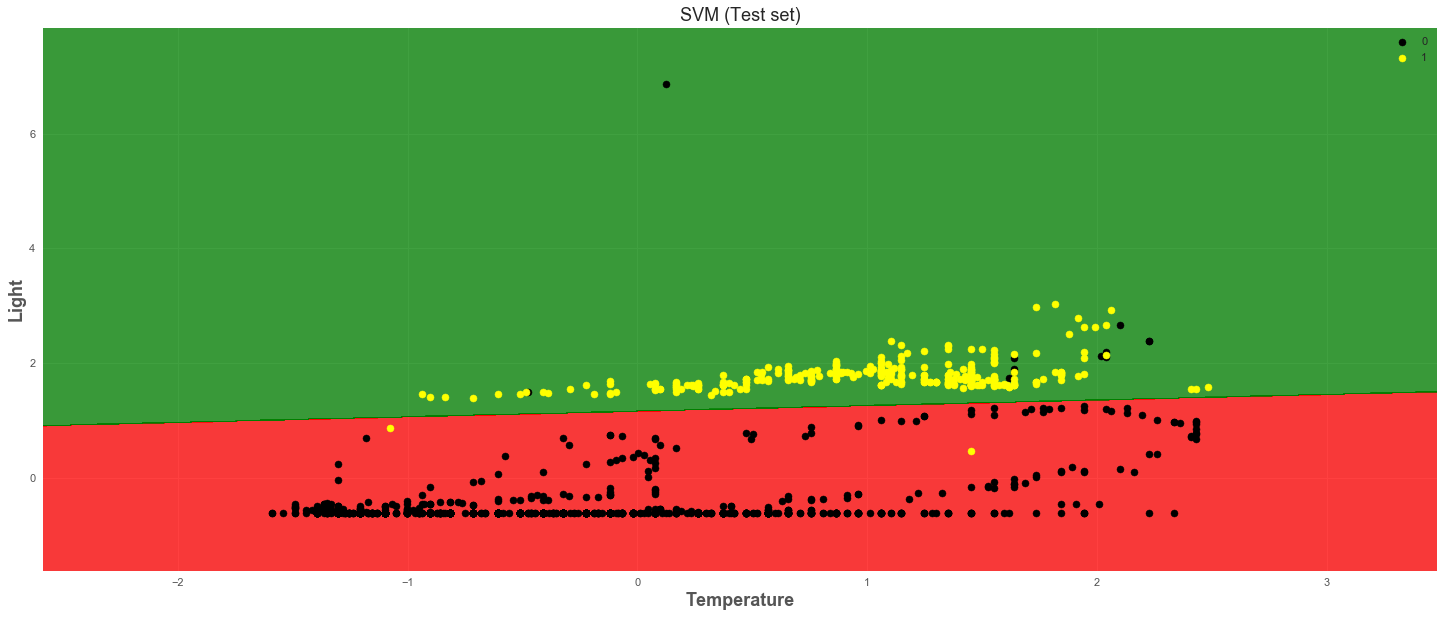

In [490]:
data = train
inputCol1 = 'Temperature'
inputCol2 = 'Light'
outputCol = 'Occupancy'
kernel = 'linear'
print "Classfication results using Temperature and Light features with Linear SVM :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


Classfication results using Temperature and Light features with NonLinear SVM(rbf kernel):

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
99.42

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
99.06


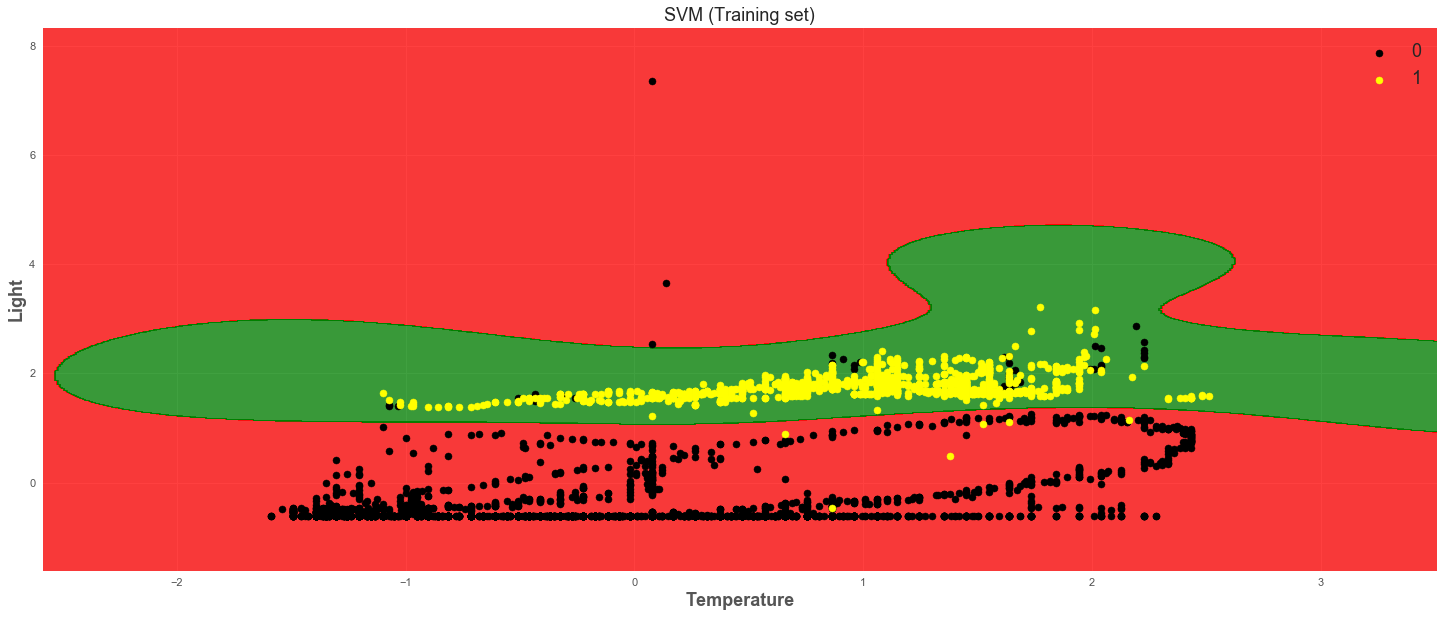

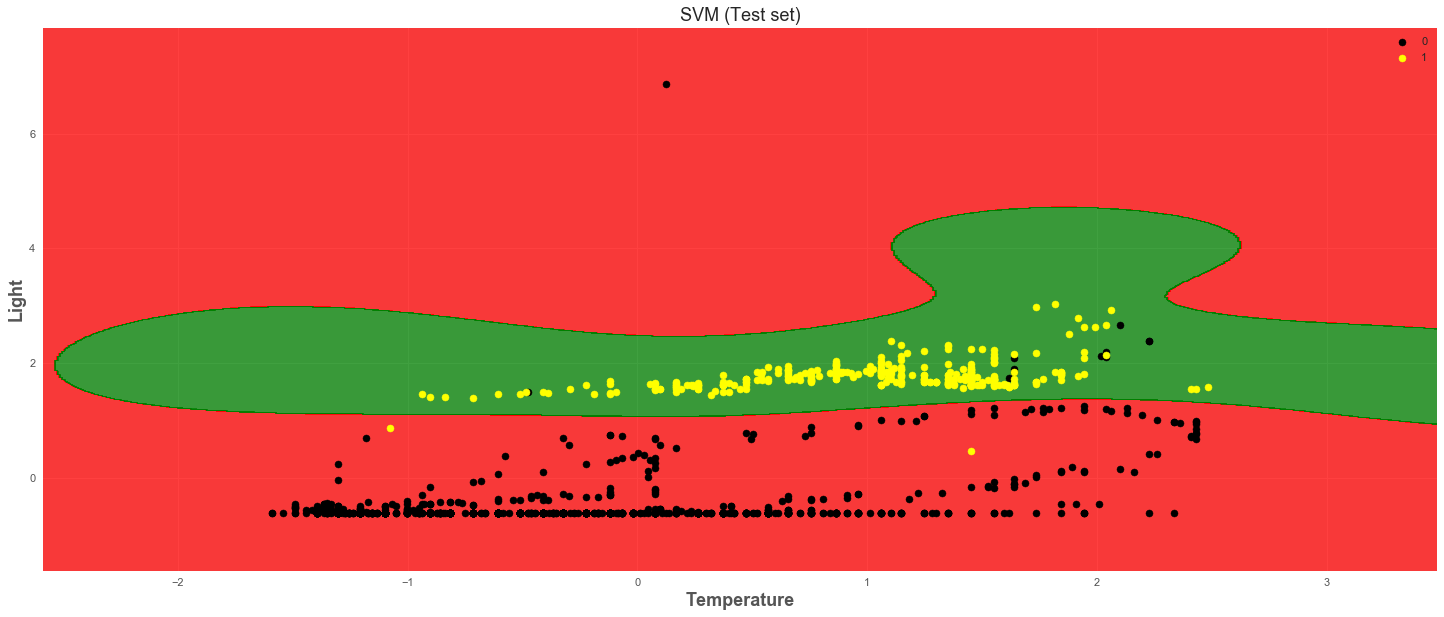

In [491]:
#Non Linear SVM
data = train
inputCol1 = 'Temperature'
inputCol2 = 'Light'
outputCol = 'Occupancy'
kernel = 'rbf'
print "Classfication results using Temperature and Light features with NonLinear SVM(rbf kernel):"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


From the above two results, it is clear that light would be a good feature for the performing occupancy classification. 

The specificity and sensitivity metrics do not show a lot of difference between linear and rbf kernel SVM. 

Also, the decision boundary shows that including rbf kernel might not be very useful and it can lead to generalization problems(overfitting) in the model.

Let's check out other input variables...

### Temperature and CO2

Classfication results using Temperature and CO2 features with Linear SVM :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
84.97

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
94.0


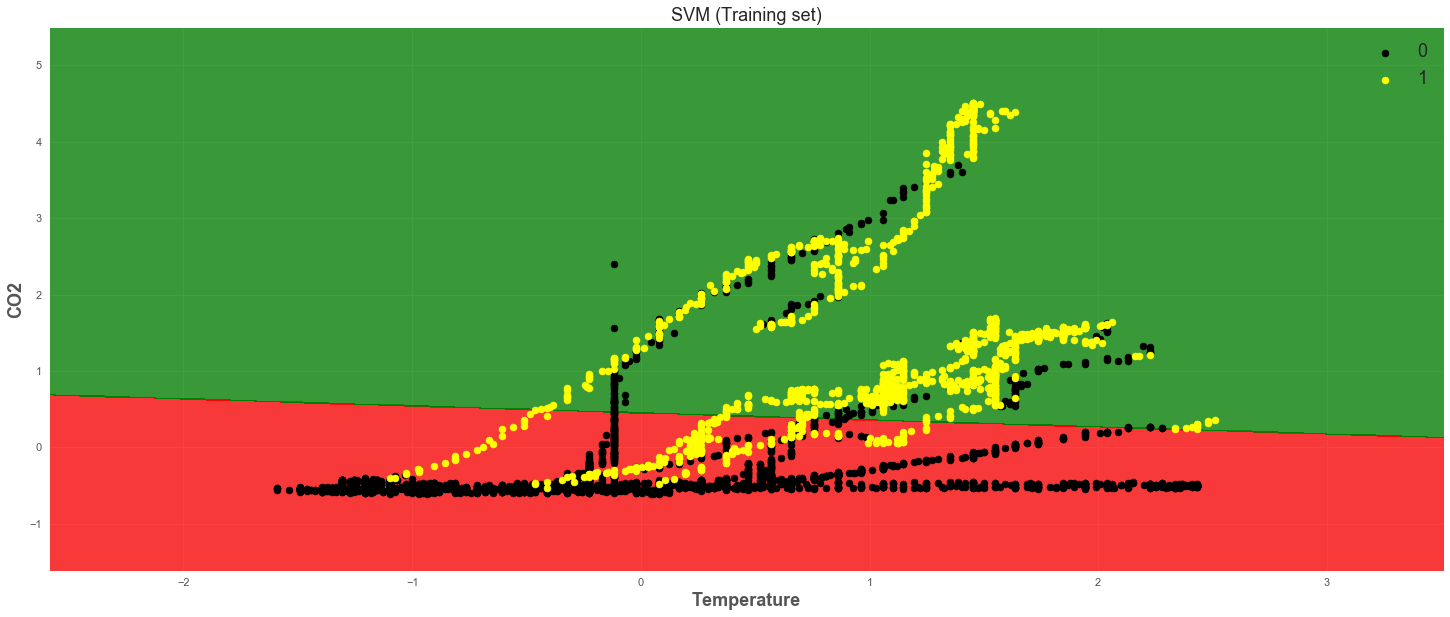

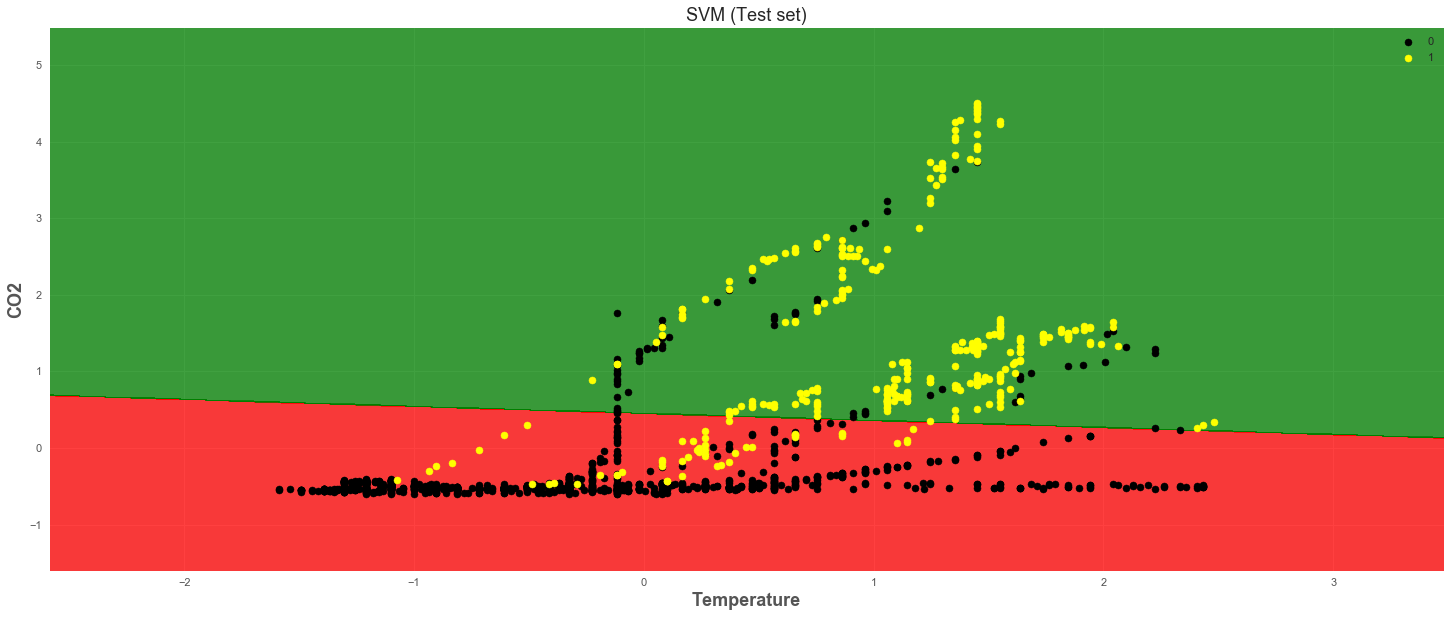

In [492]:
# Linear SVM
data = train
inputCol1 = 'Temperature'
inputCol2 = 'CO2'
outputCol = 'Occupancy'
kernel = 'linear'
print "Classfication results using Temperature and CO2 features with Linear SVM :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


Classfication results using Temperature and CO2 features with NonLinear SVM(rbf kernel) :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
85.26

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
95.32


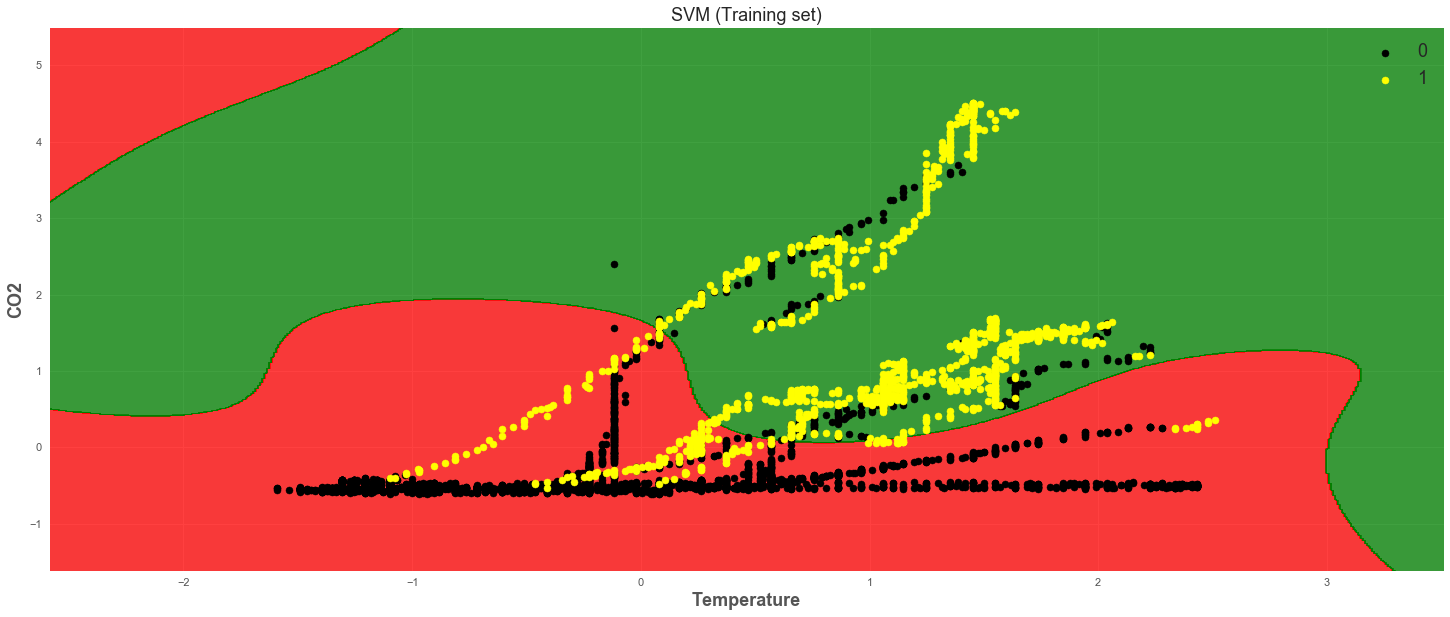

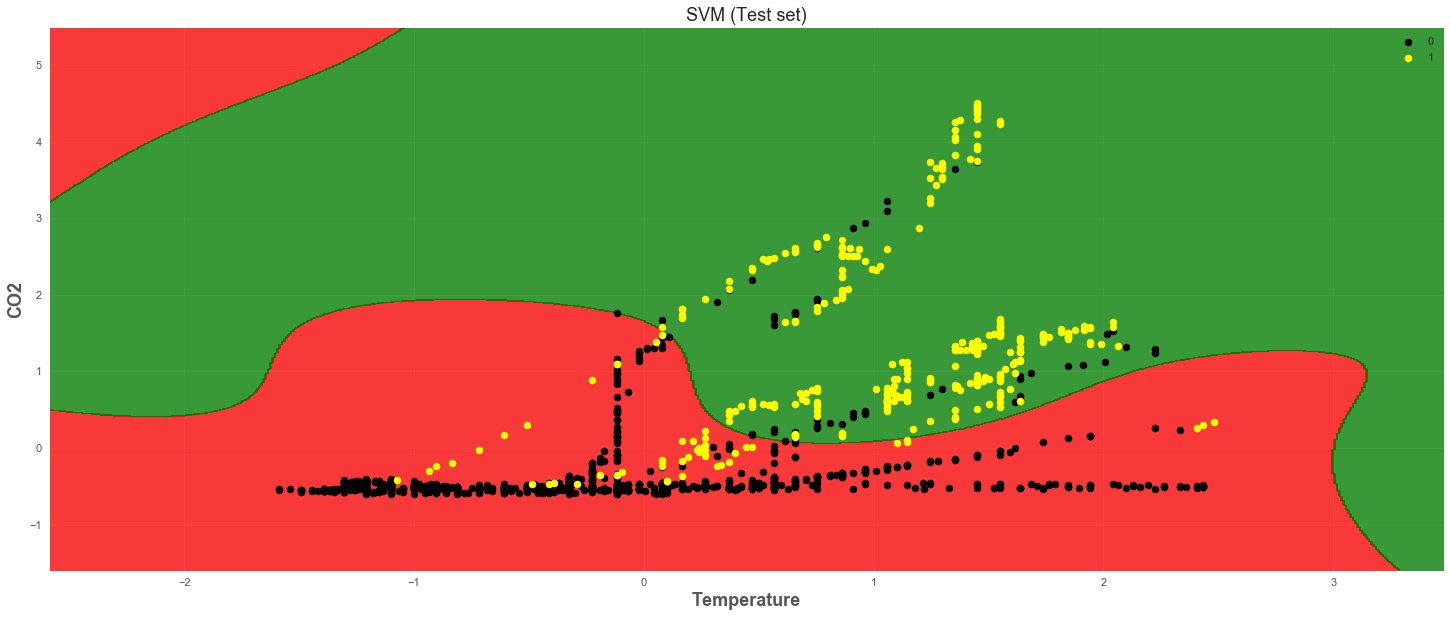

In [493]:
# Non linear SVM
data = train
inputCol1 = 'Temperature'
inputCol2 = 'CO2'
outputCol = 'Occupancy'
kernel = 'rbf'
print "Classfication results using Temperature and CO2 features with NonLinear SVM(rbf kernel) :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


Again, not a lot of difference between the ability of the linear and rbf models to classify the rooms as occupied which are actually occupied....Similar effects can be observed in specificity too!!!


### Light and CO2

Classfication results using Light and CO2 features with Linear SVM :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
99.71

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
98.99


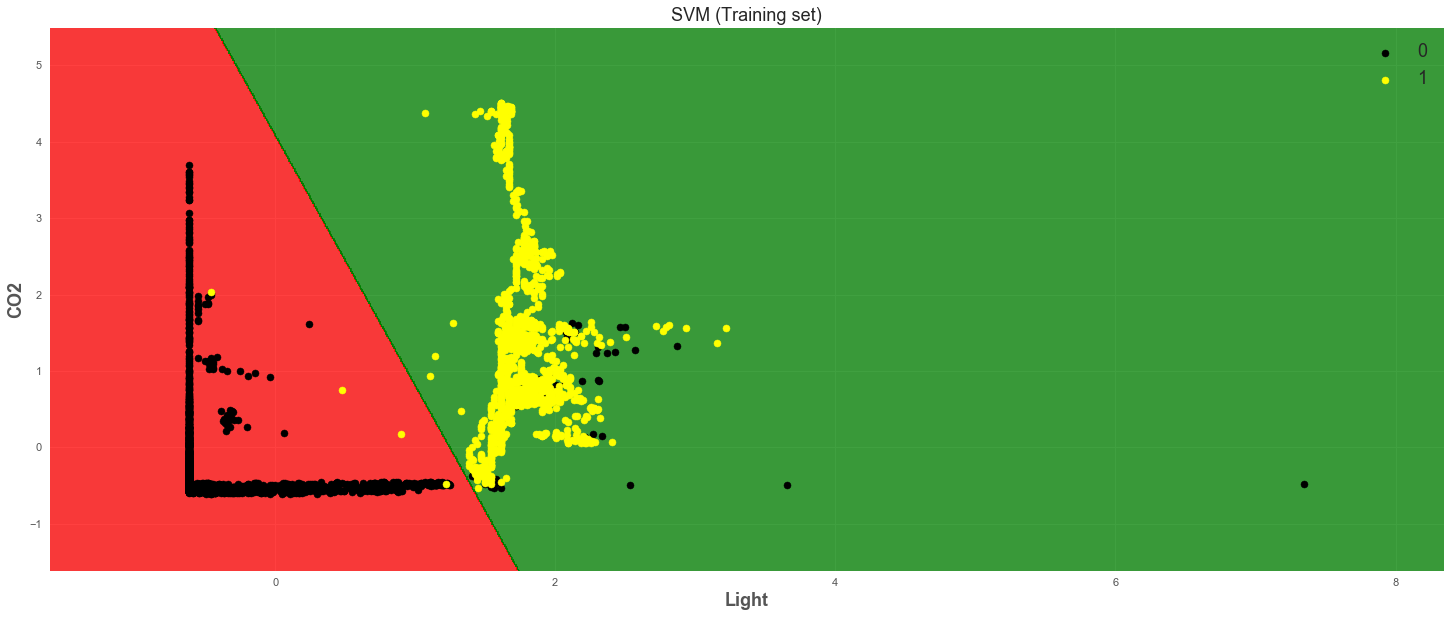

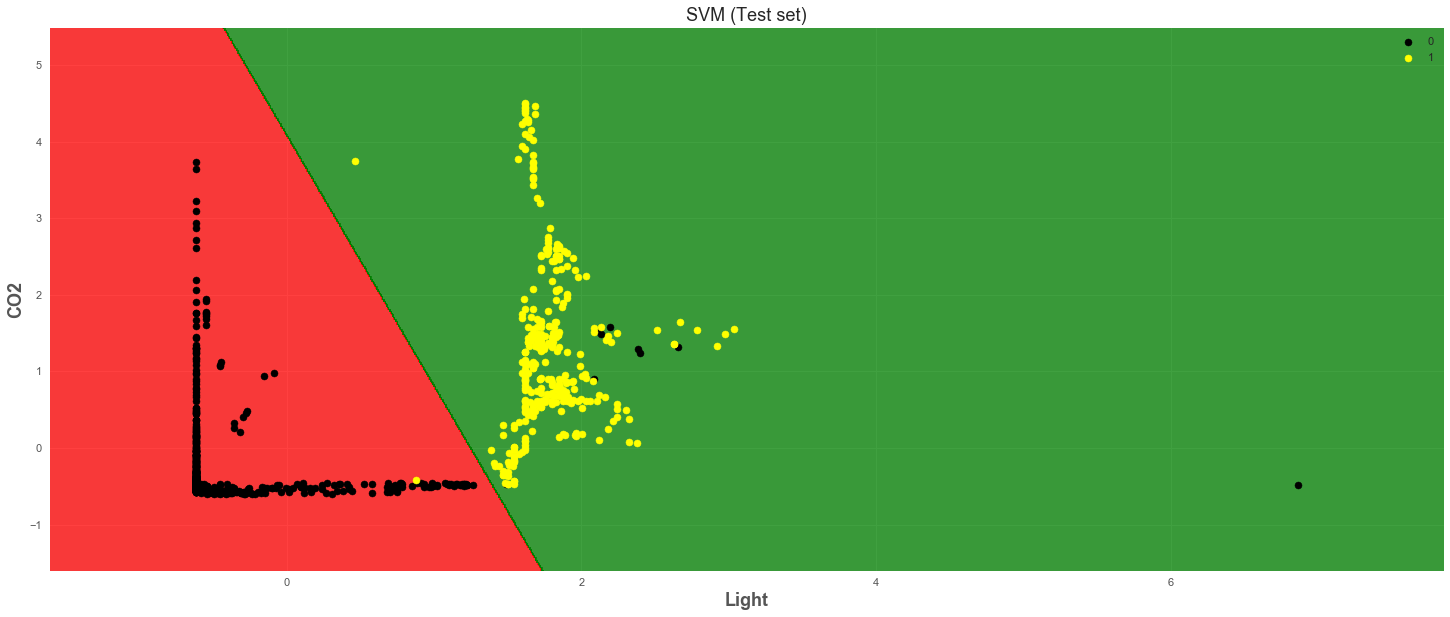

In [494]:
# Linear SVM
data = train
inputCol1 = 'Light'
inputCol2 = 'CO2'
outputCol = 'Occupancy'
kernel = 'linear'
print "Classfication results using Light and CO2 features with Linear SVM :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


Classfication results using Light and CO2 features with NonLinear SVM(rbf kernel) :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
99.71

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
99.06


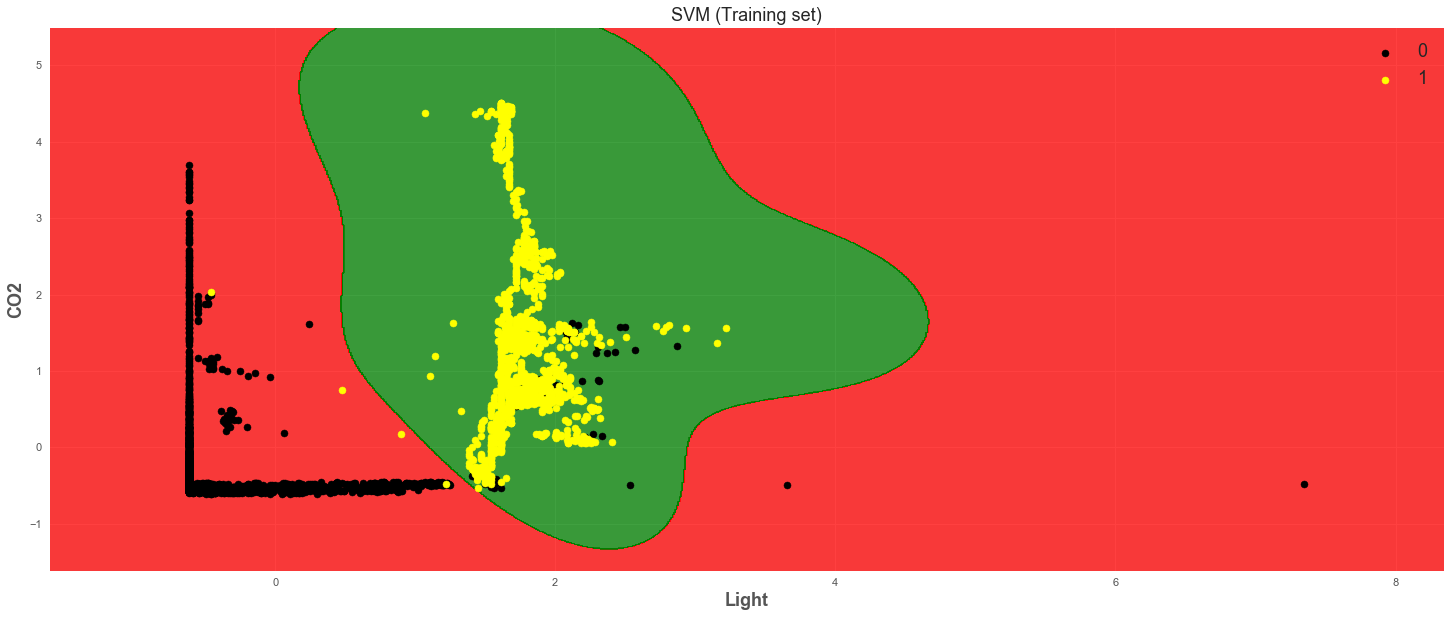

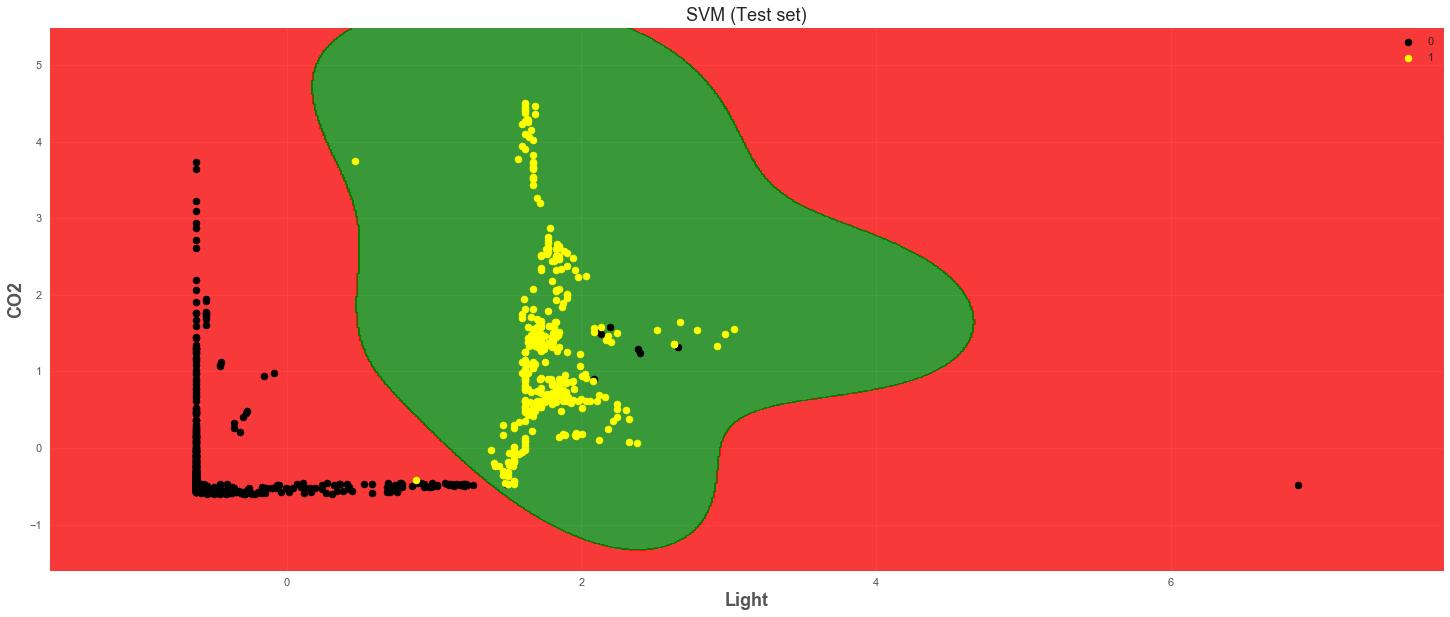

In [495]:
# NonLinear SVM
data = train
inputCol1 = 'Light'
inputCol2 = 'CO2'
outputCol = 'Occupancy'
kernel = 'rbf'
print "Classfication results using Light and CO2 features with NonLinear SVM(rbf kernel) :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)

Similar results are obtained with Light and CO2 variables too. It would be wise to use linear SVM only for the final modeling purposes...

Let's confirm the kernel results with other variables too!!!

### Light and Humidity

Classfication results using Light and Humidity features with Linear SVM :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
99.42

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
98.99


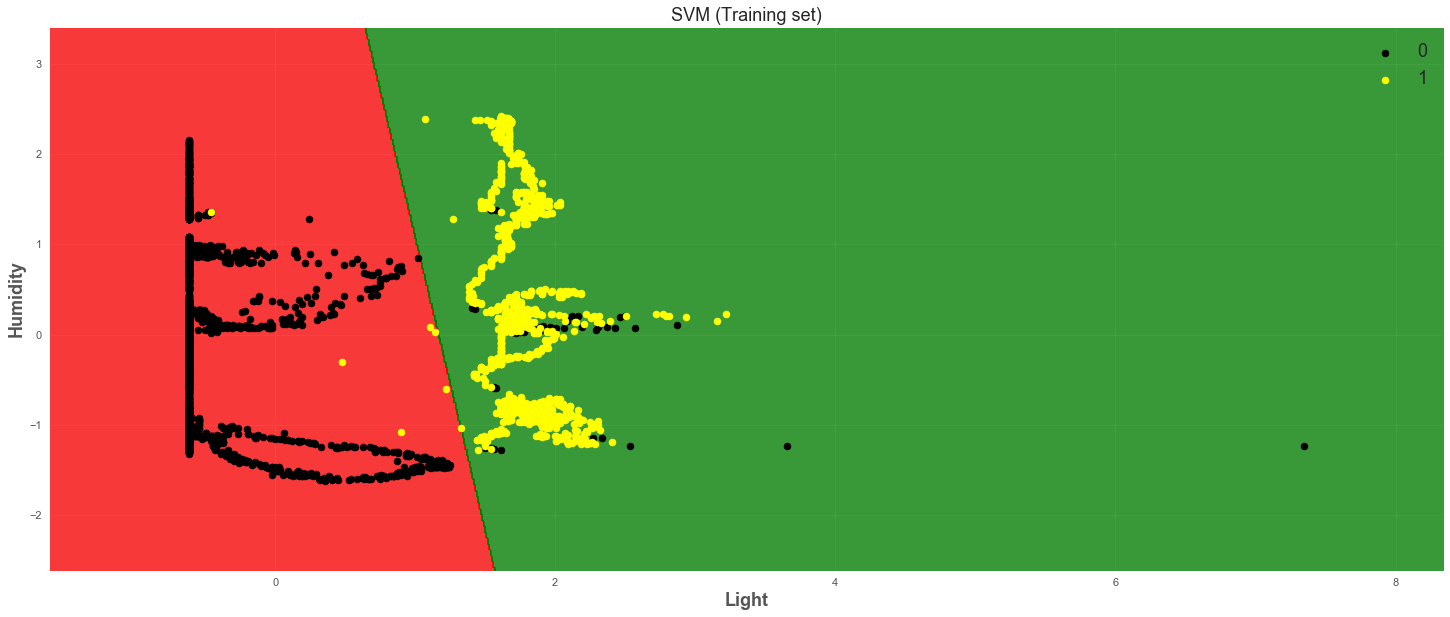

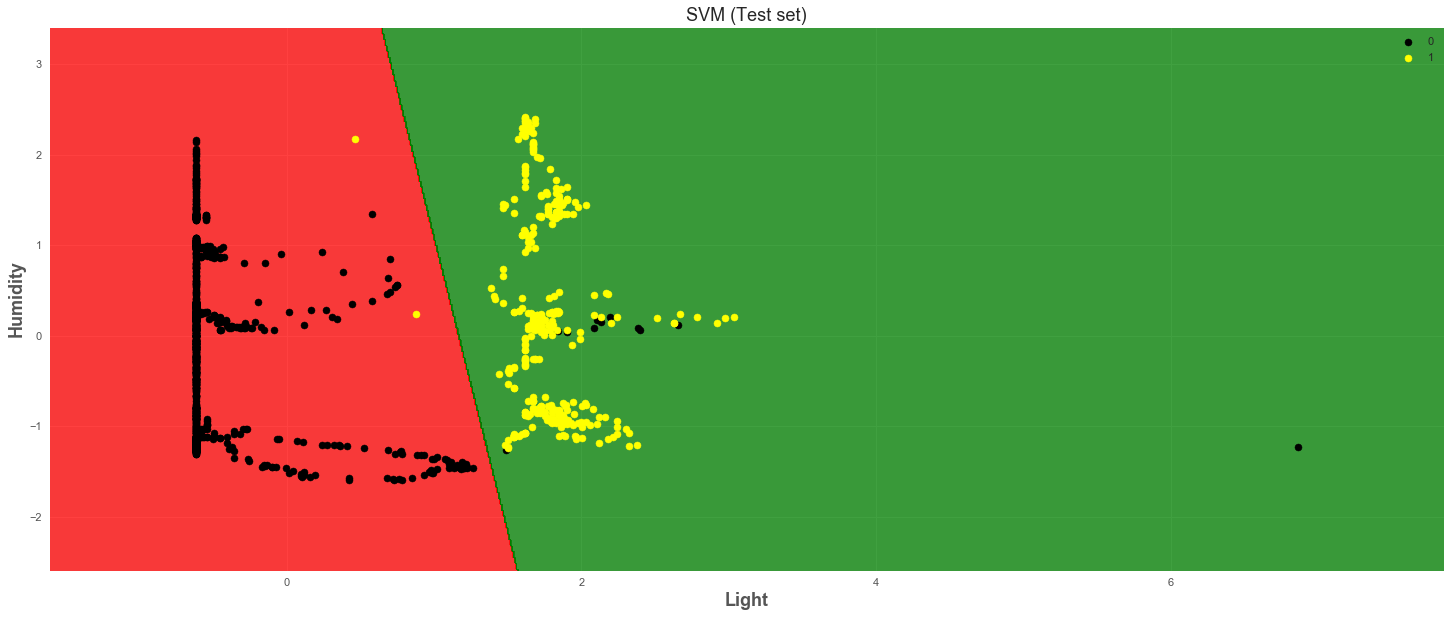

In [496]:
# Linear SVM
data = train
inputCol1 = 'Light'
inputCol2 = 'Humidity'
outputCol = 'Occupancy'
kernel = 'linear'
print "Classfication results using Light and Humidity features with Linear SVM :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


Classfication results using Light and Humidity features with NonLinear SVM(rbf kernel) :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
99.42

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
99.06


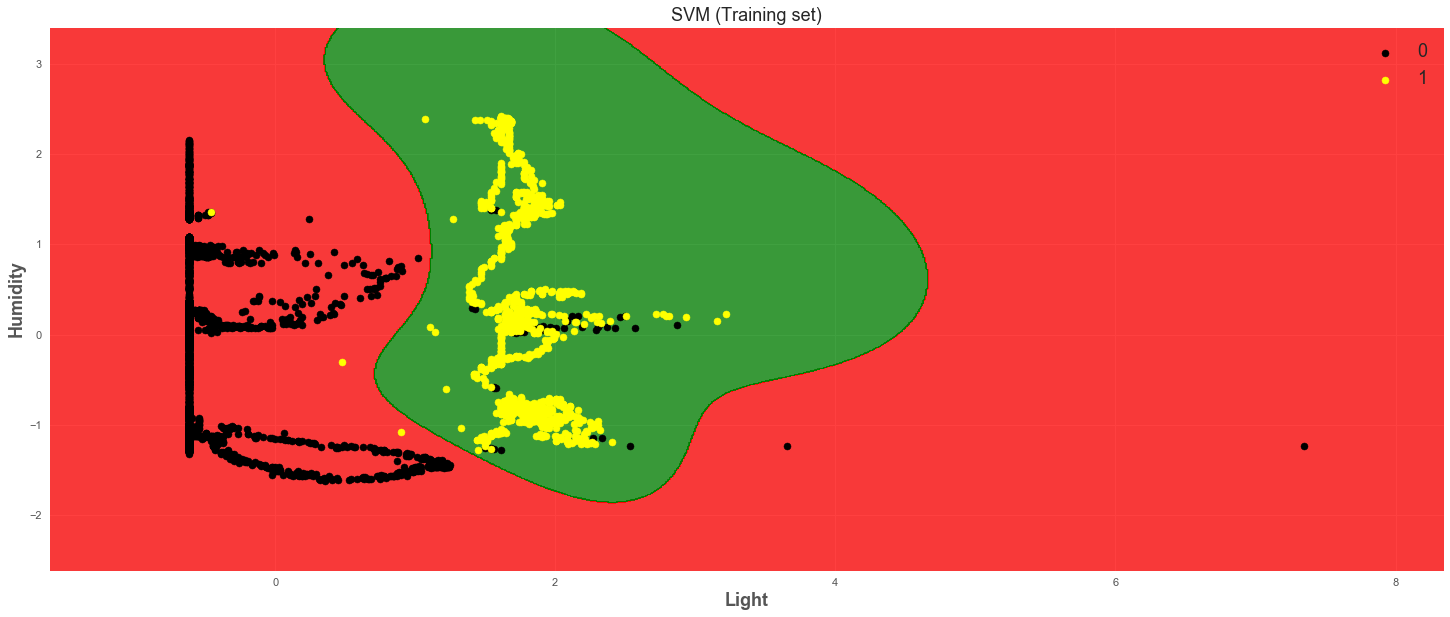

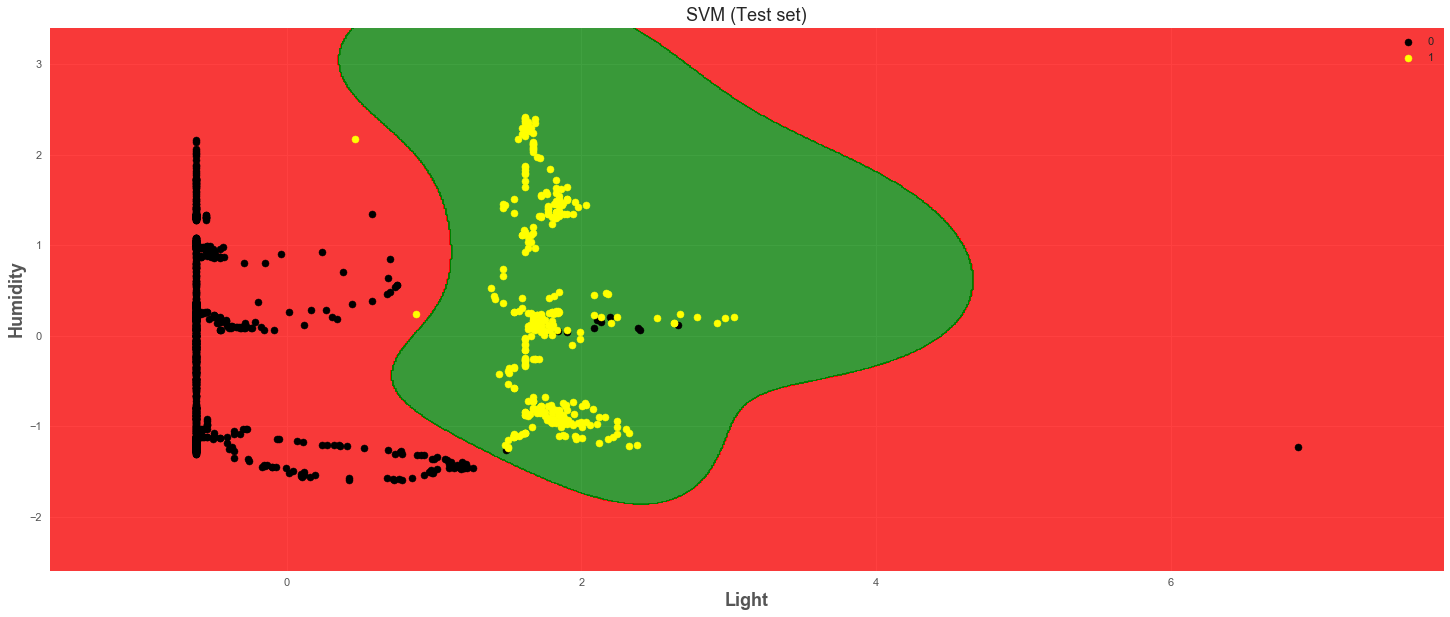

In [497]:
# NonLinear SVM
data = train
inputCol1 = 'Light'
inputCol2 = 'Humidity'
outputCol = 'Occupancy'
kernel = 'rbf'
print "Classfication results using Light and Humidity features with NonLinear SVM(rbf kernel) :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)

Humidity does not look very useful in this classification task. Rooms seem to be non occupied irrespective of change in the humidity values(Denoted by black points).

### Temperature and Humidity

Classfication results using Temperature and Humidity features with Linear SVM :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
53.76

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
92.67


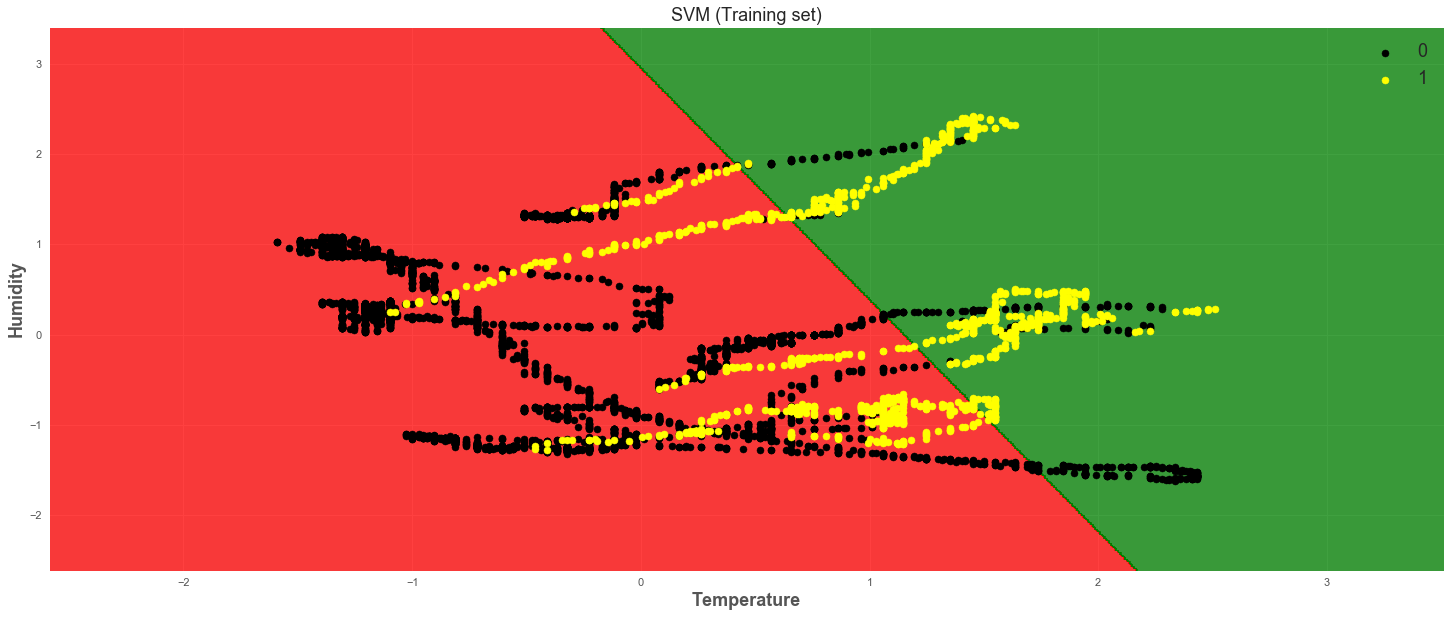

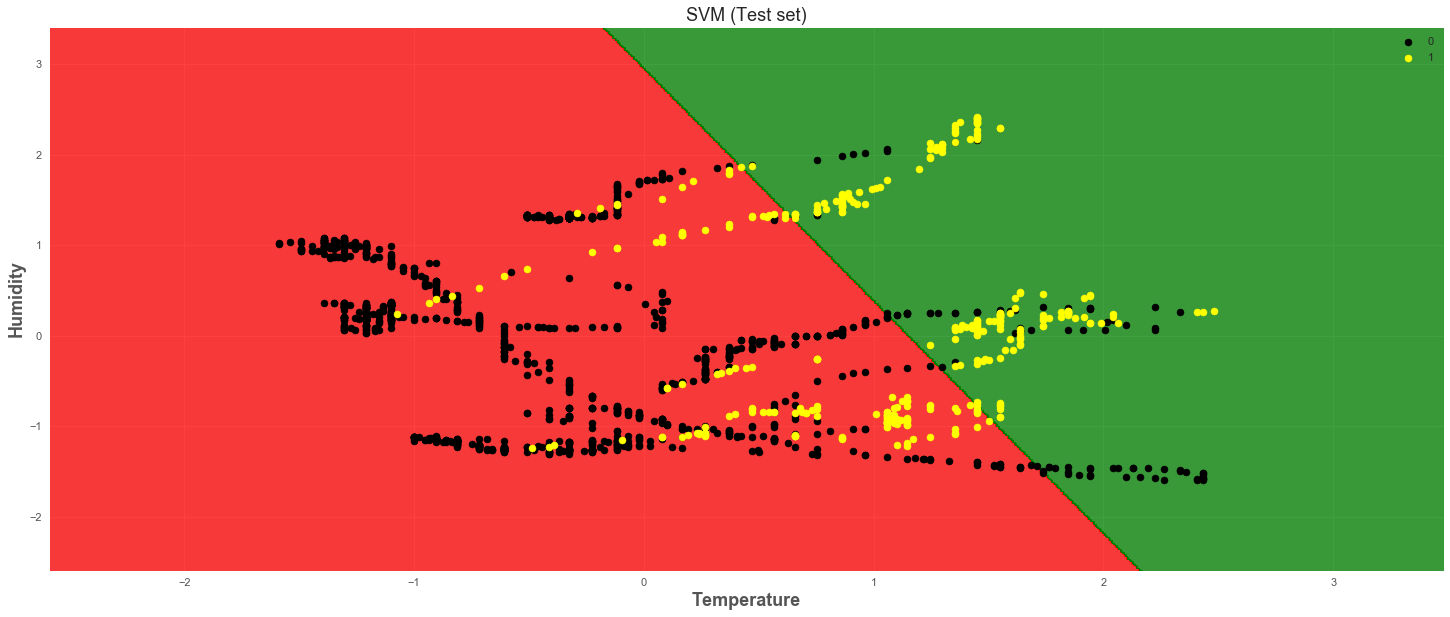

In [498]:
# Linear SVM
data = train
inputCol1 = 'Temperature'
inputCol2 = 'Humidity'
outputCol = 'Occupancy'
kernel = 'linear'
print "Classfication results using Temperature and Humidity features with Linear SVM :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


Classfication results using Temperature and Humidity features with NonLinear SVM(rbf kernel) :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
79.48

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
94.93


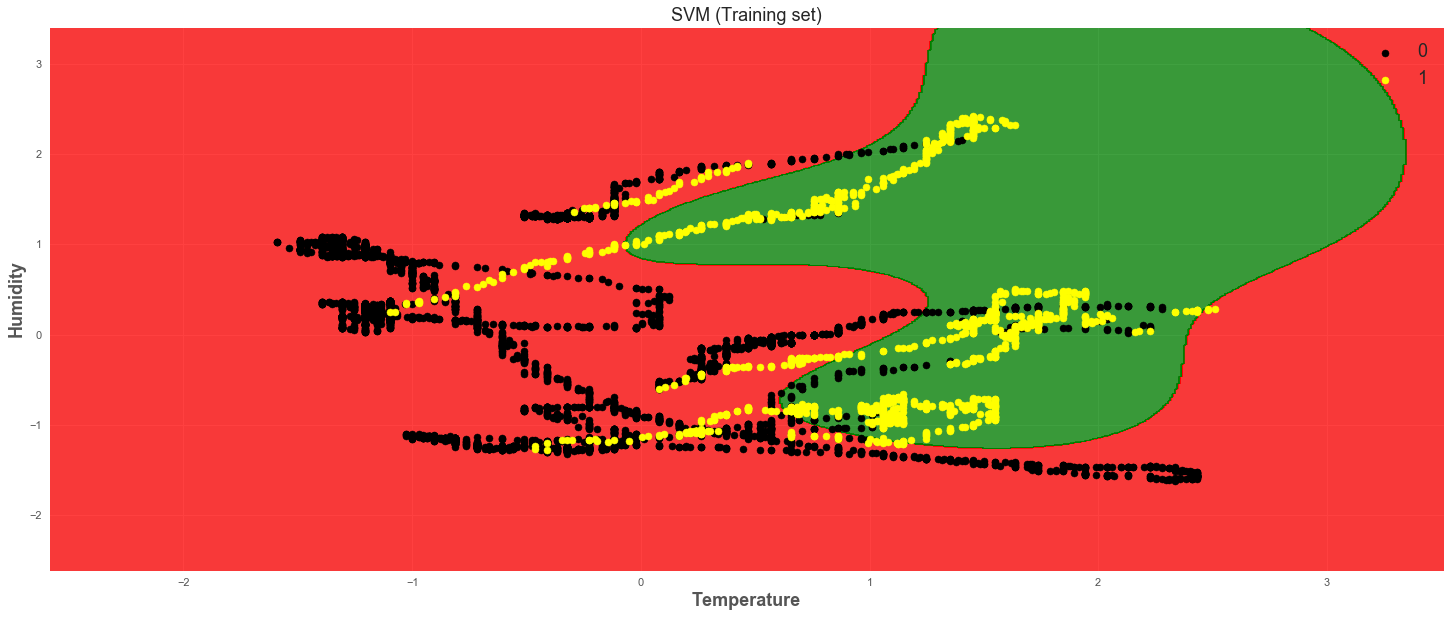

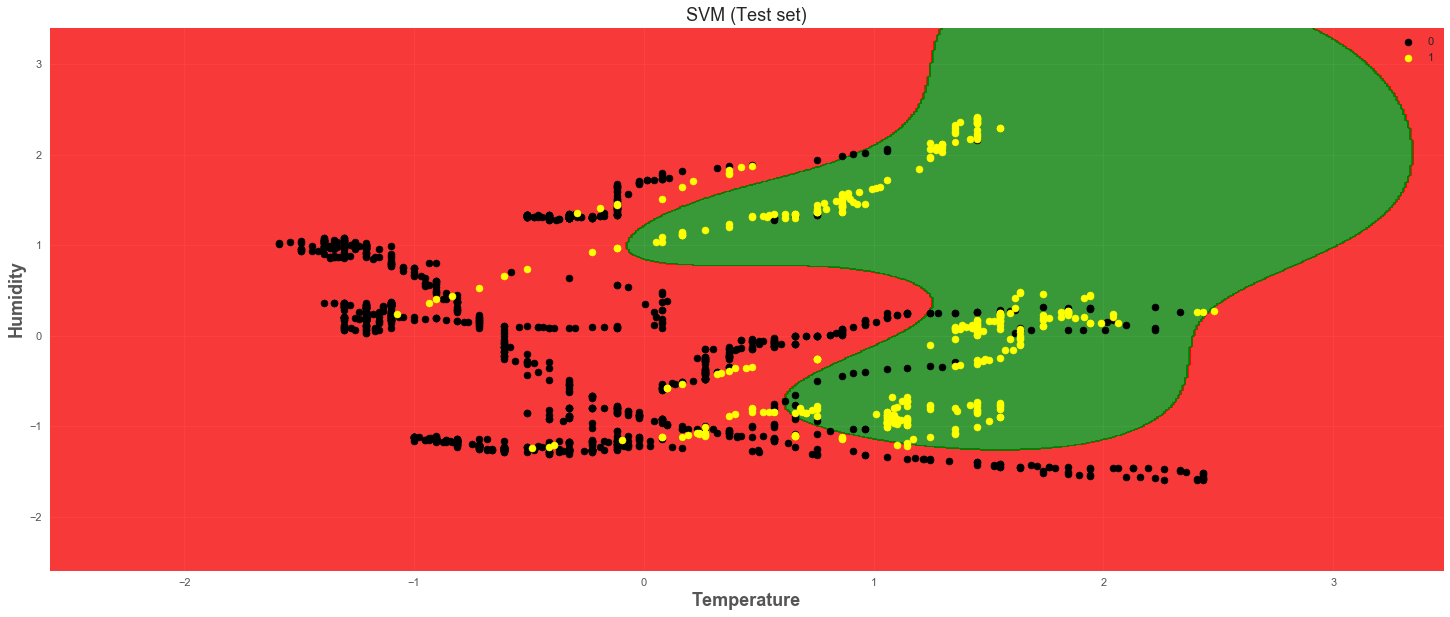

In [499]:
# NonLinear SVM
data = train
inputCol1 = 'Temperature'
inputCol2 = 'Humidity'
outputCol = 'Occupancy'
kernel = 'rbf'
print "Classfication results using Temperature and Humidity features with NonLinear SVM(rbf kernel) :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)

Temperature makes a very little sense in this clasification as well. This is quite intuitive because some employees might like to keep the air conditioning running at lower temperatures, some might like it higher!!!! So, we can't really say a lot about whether a room is occupied or not.

### CO2 and Humidity

Classfication results using CO2 and Humidity features with Linear SVM :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
83.53

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
95.25


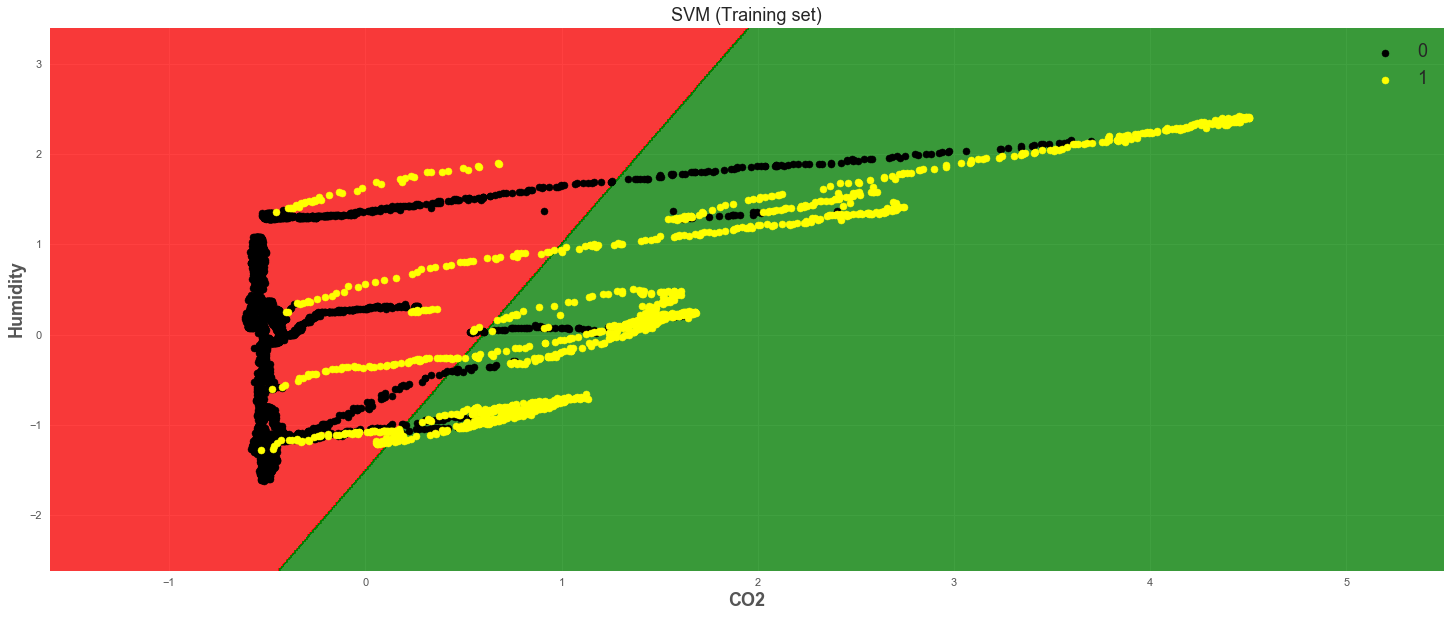

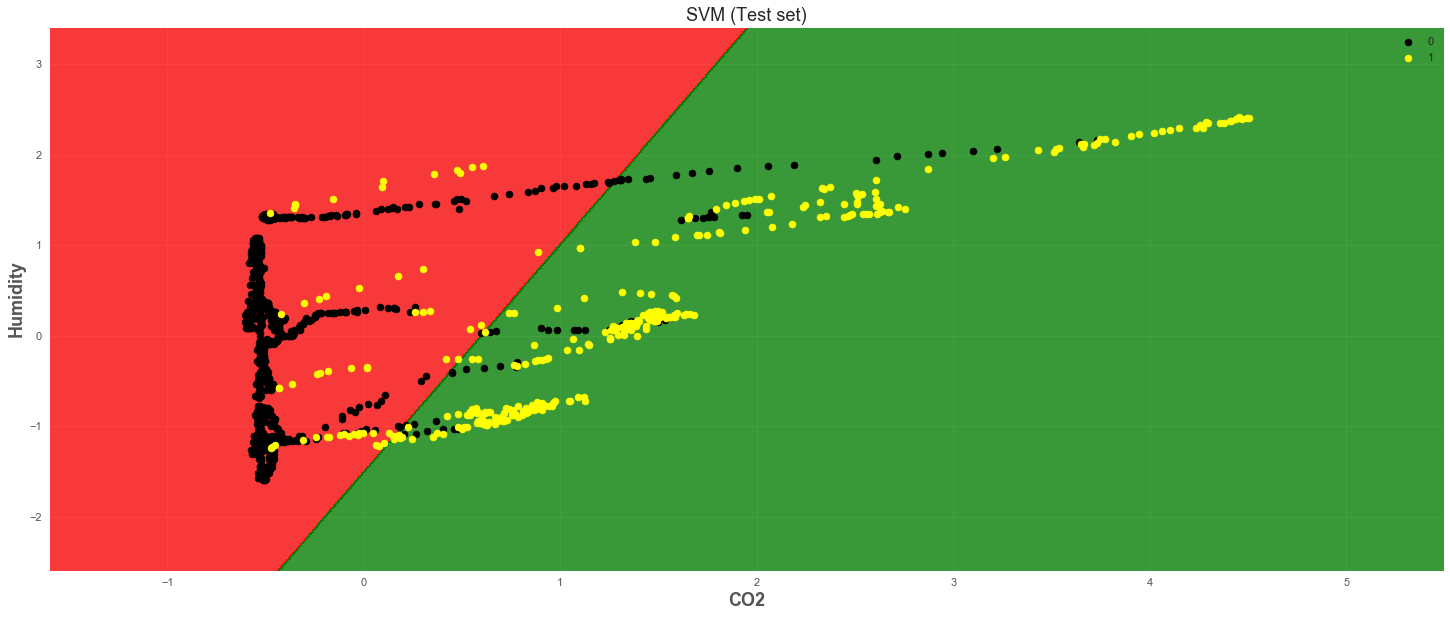

In [500]:
# Linear SVM
data = train
inputCol1 = 'CO2'
inputCol2 = 'Humidity'
outputCol = 'Occupancy'
kernel = 'linear'
print "Classfication results using CO2 and Humidity features with Linear SVM :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


Classfication results using CO2 and Humidity features with NonLinear SVM(rbf kernel) :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
86.99

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
96.1


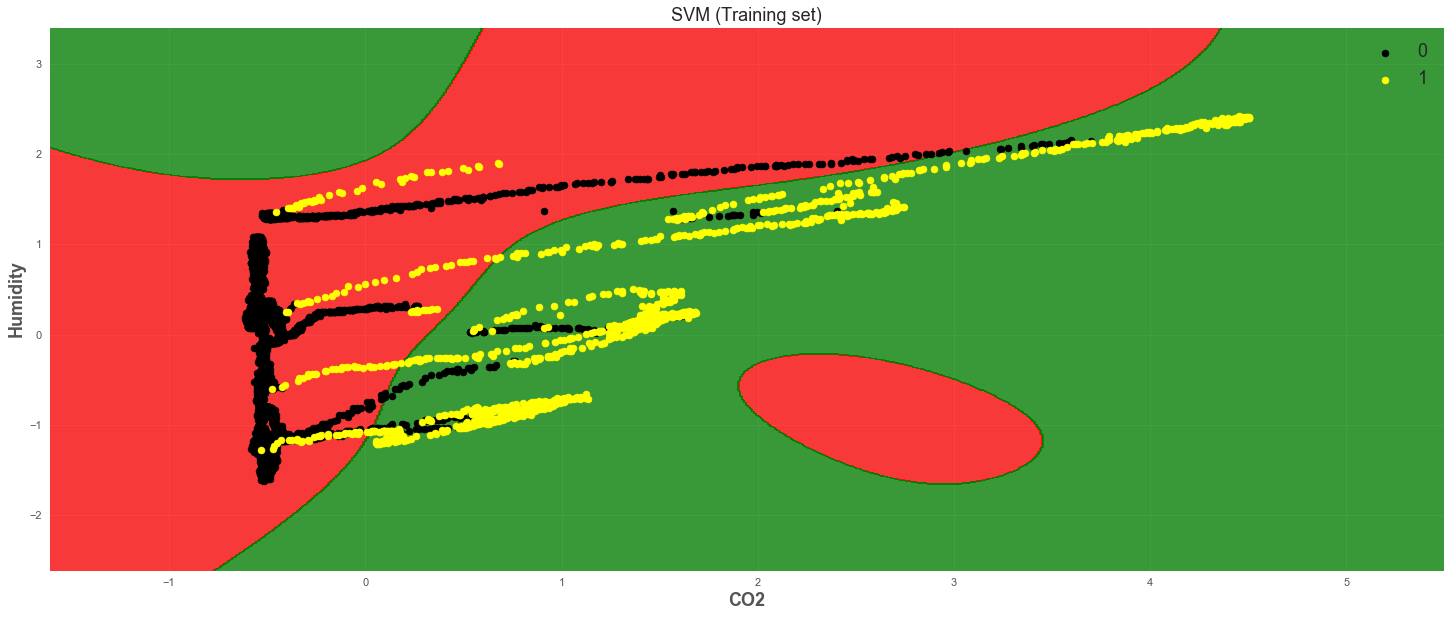

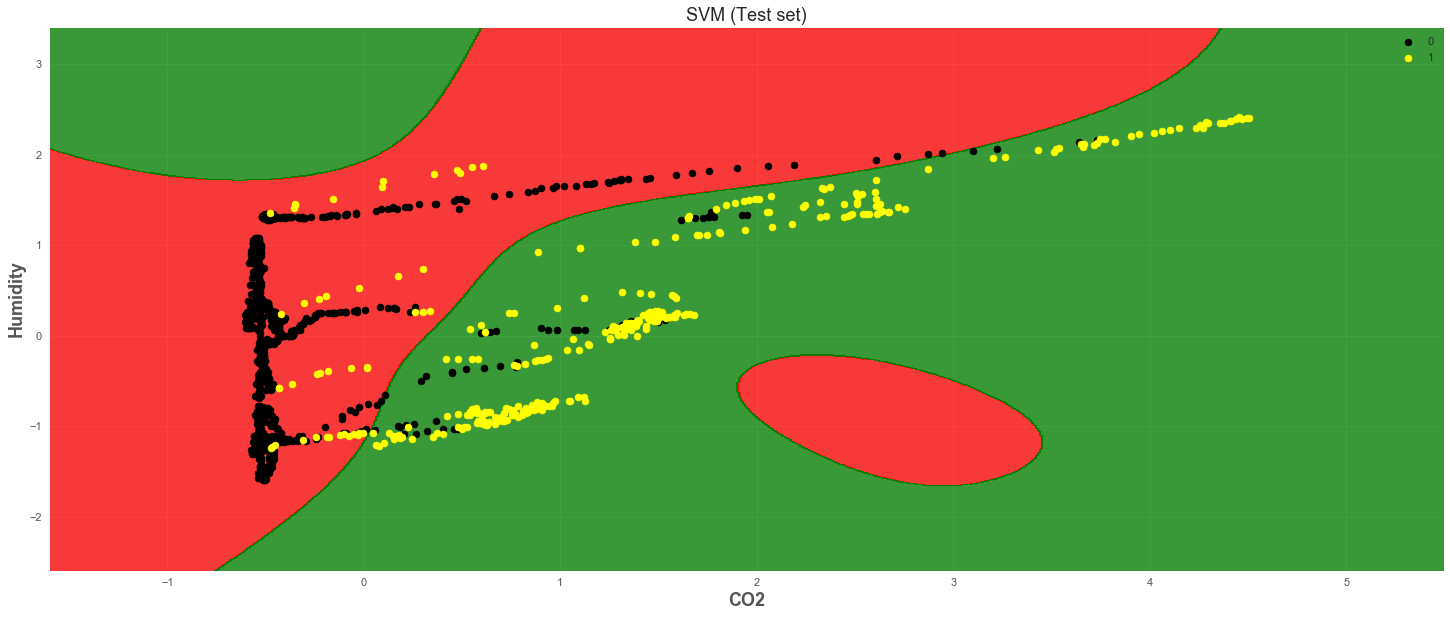

In [501]:
# NonLinear SVM
data = train
inputCol1 = 'CO2'
inputCol2 = 'Humidity'
outputCol = 'Occupancy'
kernel = 'rbf'
print "Classfication results using CO2 and Humidity features with NonLinear SVM(rbf kernel) :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)

CO2 level would increase with more people in the room. Hence, CO2 can be used as the predictor. Again, the specificity and sensitivity values of the model do not show a lot of difference between linear and rbf kernel SVM. So, it might be prudent to go with linear classifier to avoid overfitting.

### Temperature and HumidityRatio

Classfication results using Temperature and HumidityRatio features with Linear SVM :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
53.18

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
93.14


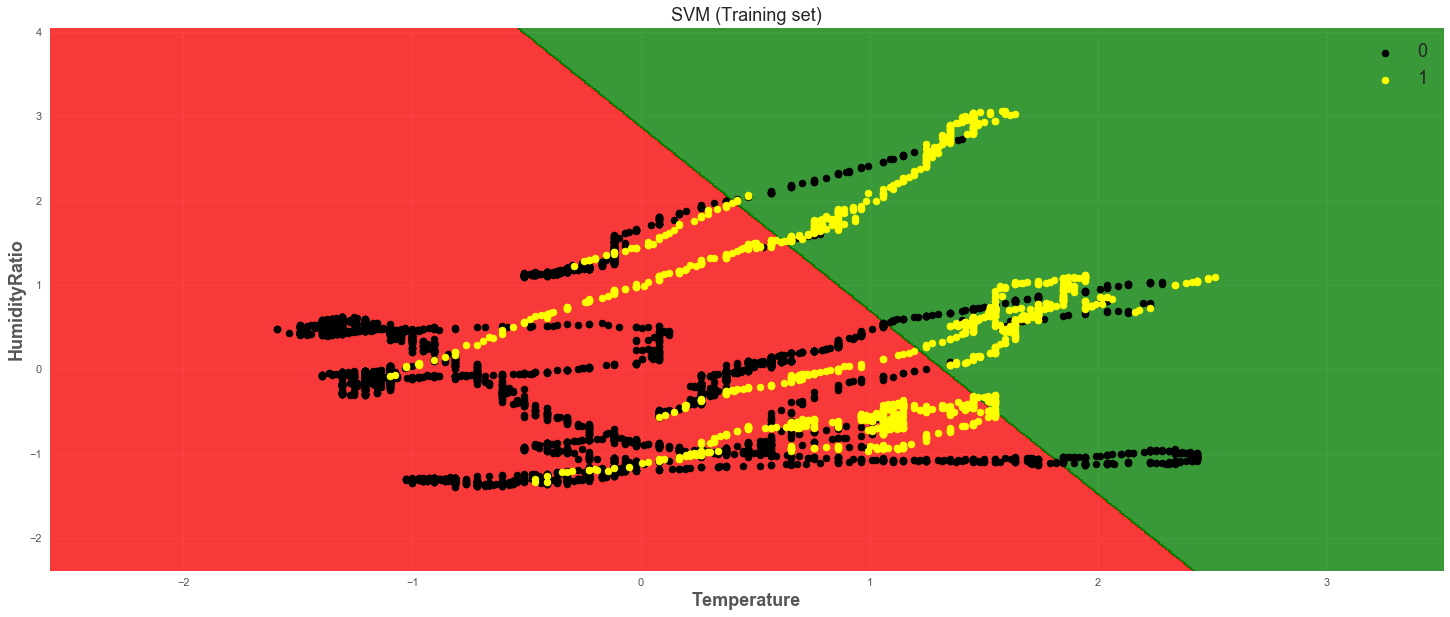

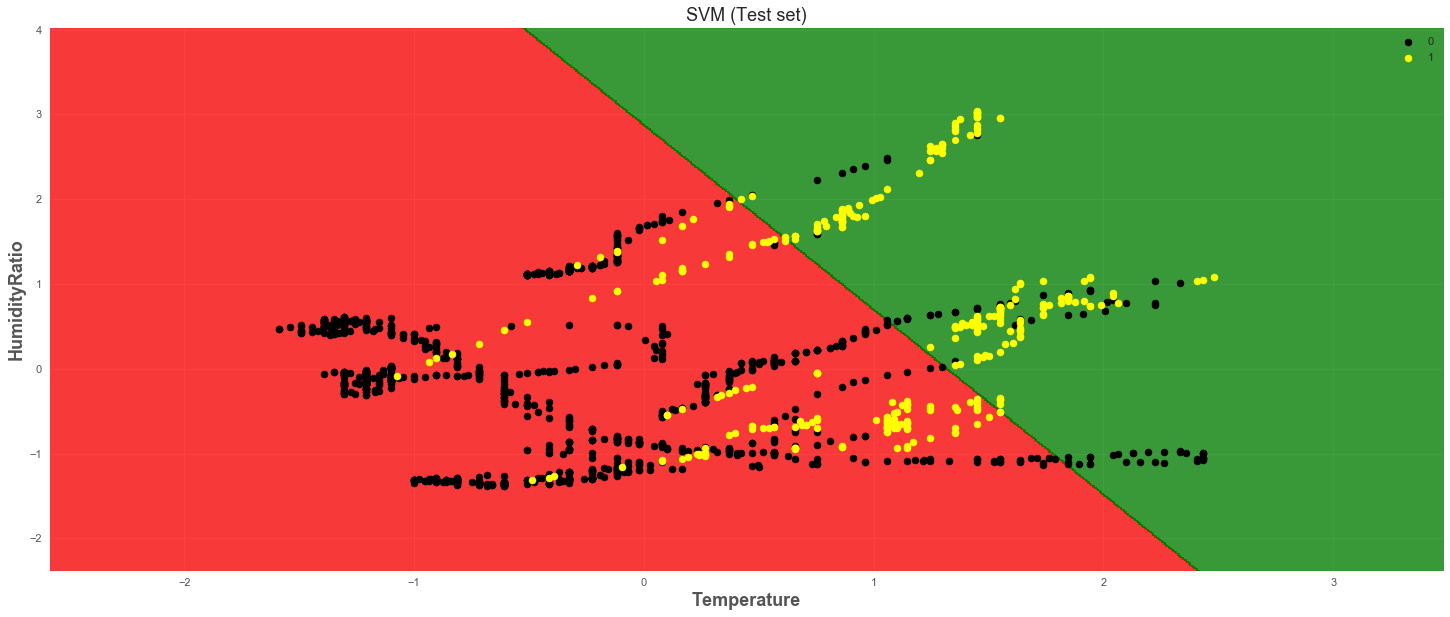

In [502]:
# Linear SVM
data = train
inputCol1 = 'Temperature'
inputCol2 = 'HumidityRatio'
outputCol = 'Occupancy'
kernel = 'linear'
print "Classfication results using Temperature and HumidityRatio features with Linear SVM :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


Classfication results using Temperature and HumidityRatio features with NonLinear SVM(rbf kernel) :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
78.61

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
95.09


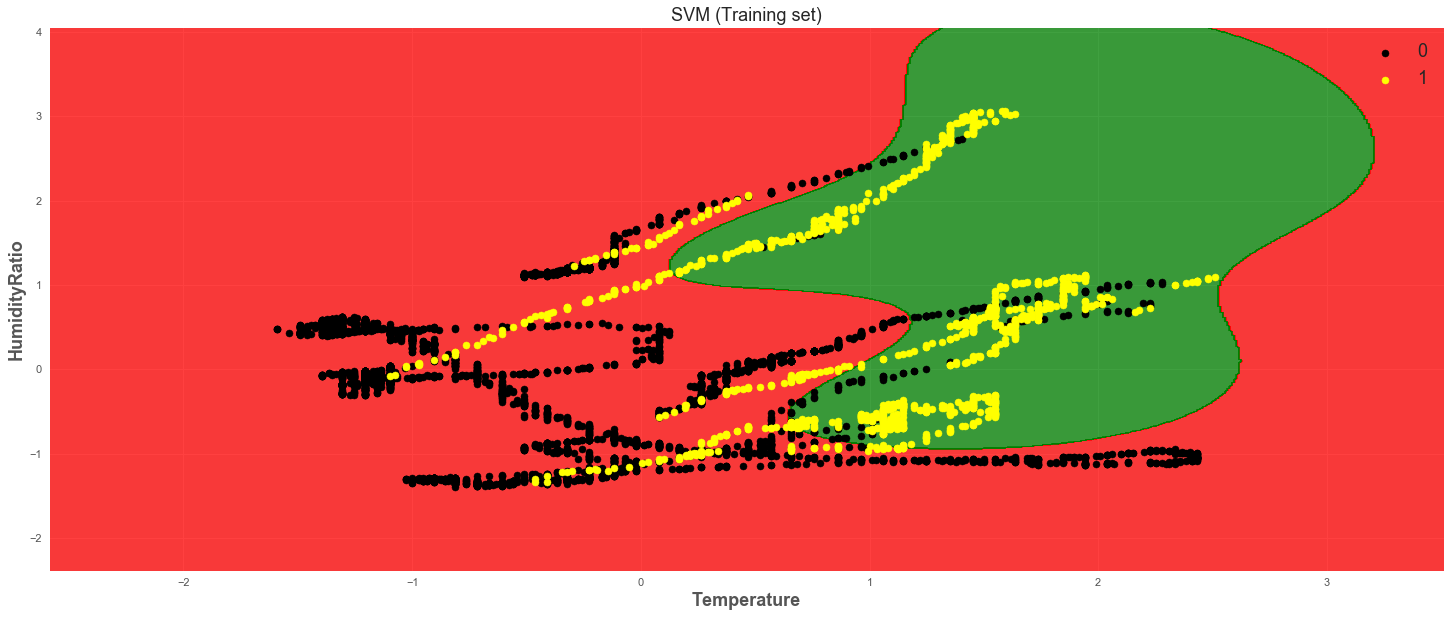

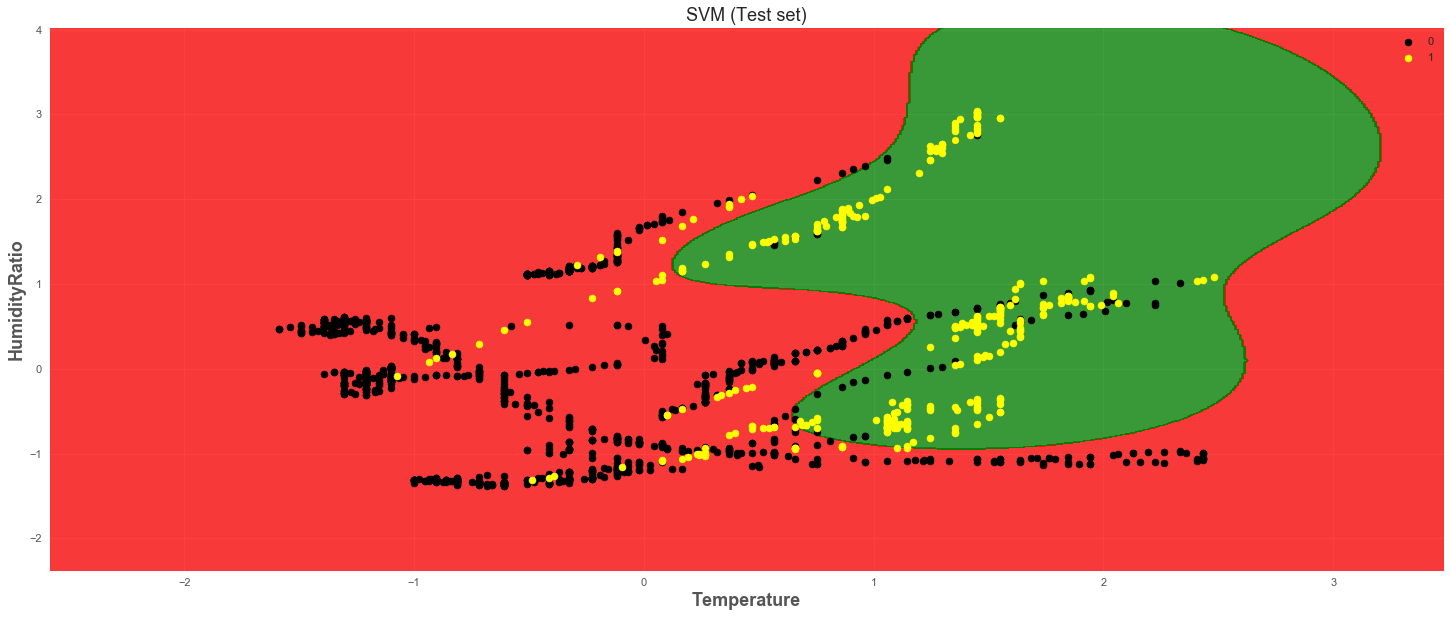

In [503]:
# NonLinear SVM
data = train
inputCol1 = 'Temperature'
inputCol2 = 'HumidityRatio'
outputCol = 'Occupancy'
kernel = 'rbf'
print "Classfication results using Temperature and HumidityRatio features with NonLinear SVM(rbf kernel) :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)

There seems to be a visible difference in the ability of the model to classify the room as occupied when it is actually occupied with rbf model showing better results than linear. But temperature and humidityratio do not seem very good features. So, I would not be thinking too much about non linear SVMs at this point.

### Light and HumidityRatio

Classfication results using Light and HumidityRatio features with Linear SVM :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
99.42

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
98.99


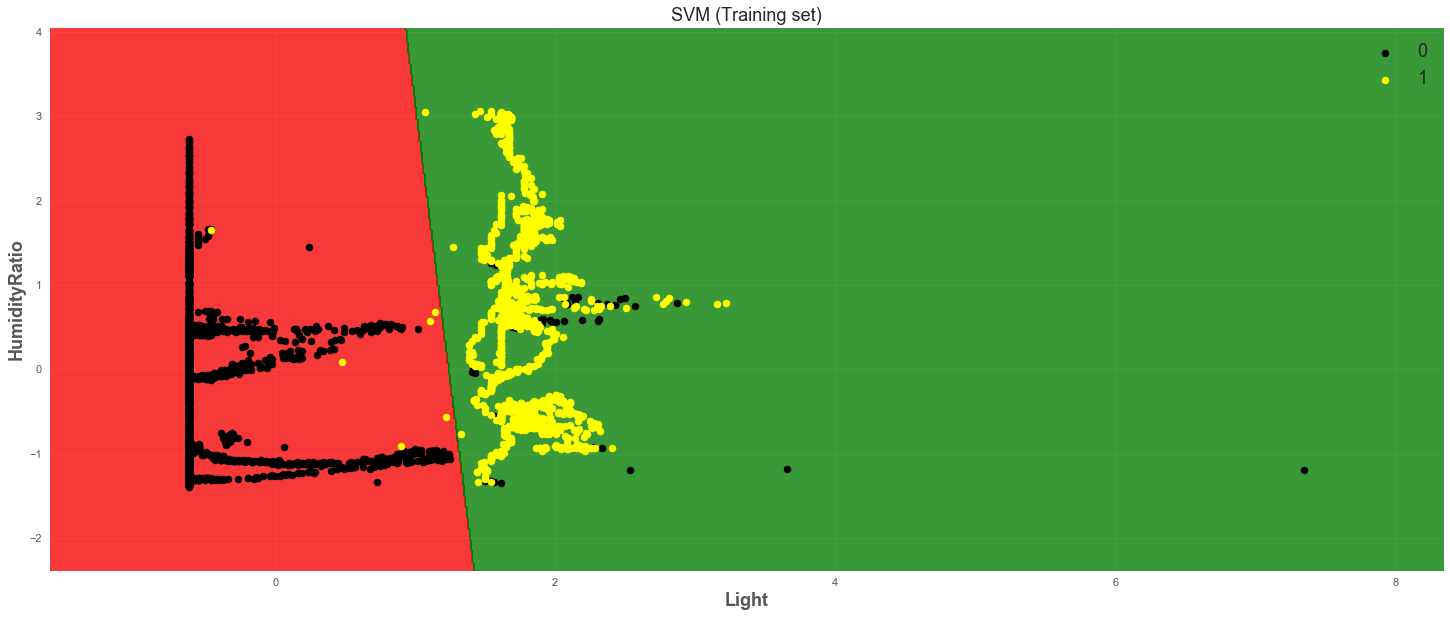

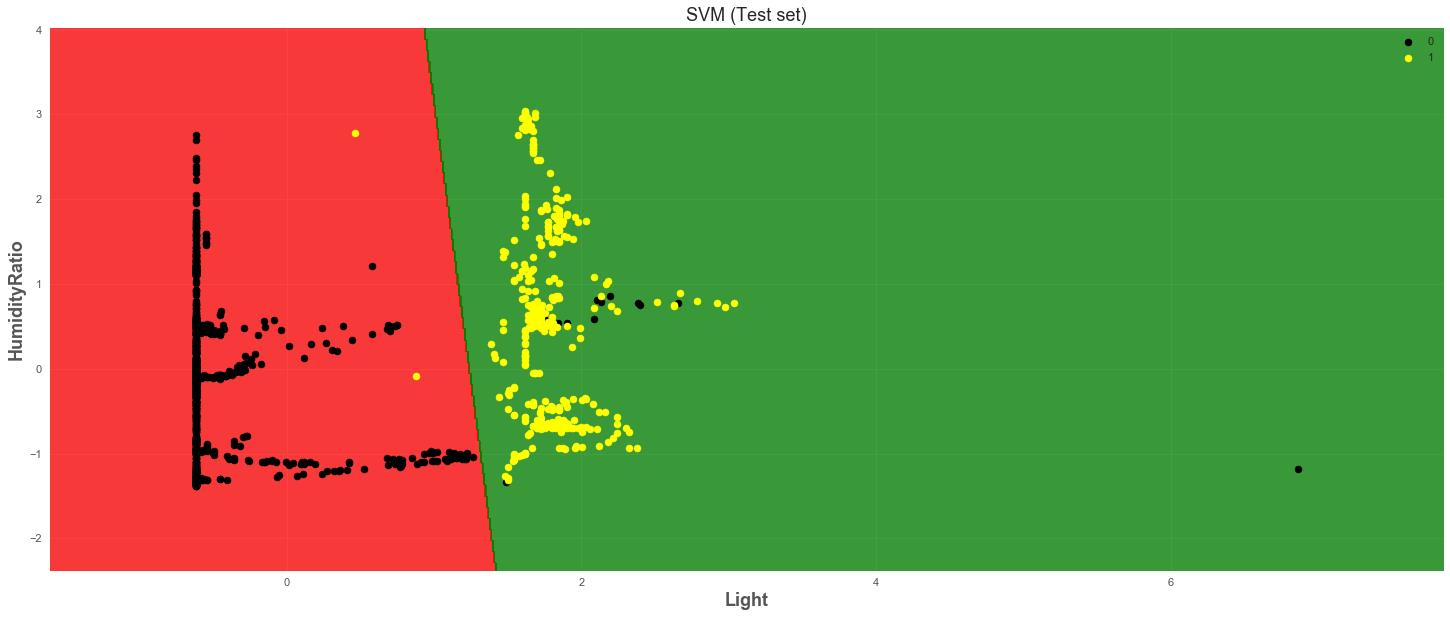

In [504]:
# Linear SVM
data = train
inputCol1 = 'Light'
inputCol2 = 'HumidityRatio'
outputCol = 'Occupancy'
kernel = 'linear'
print "Classfication results using Light and HumidityRatio features with Linear SVM :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


Classfication results using Light and HumidityRatio features with NonLinear SVM(rbf kernel) :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
99.71

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
99.06


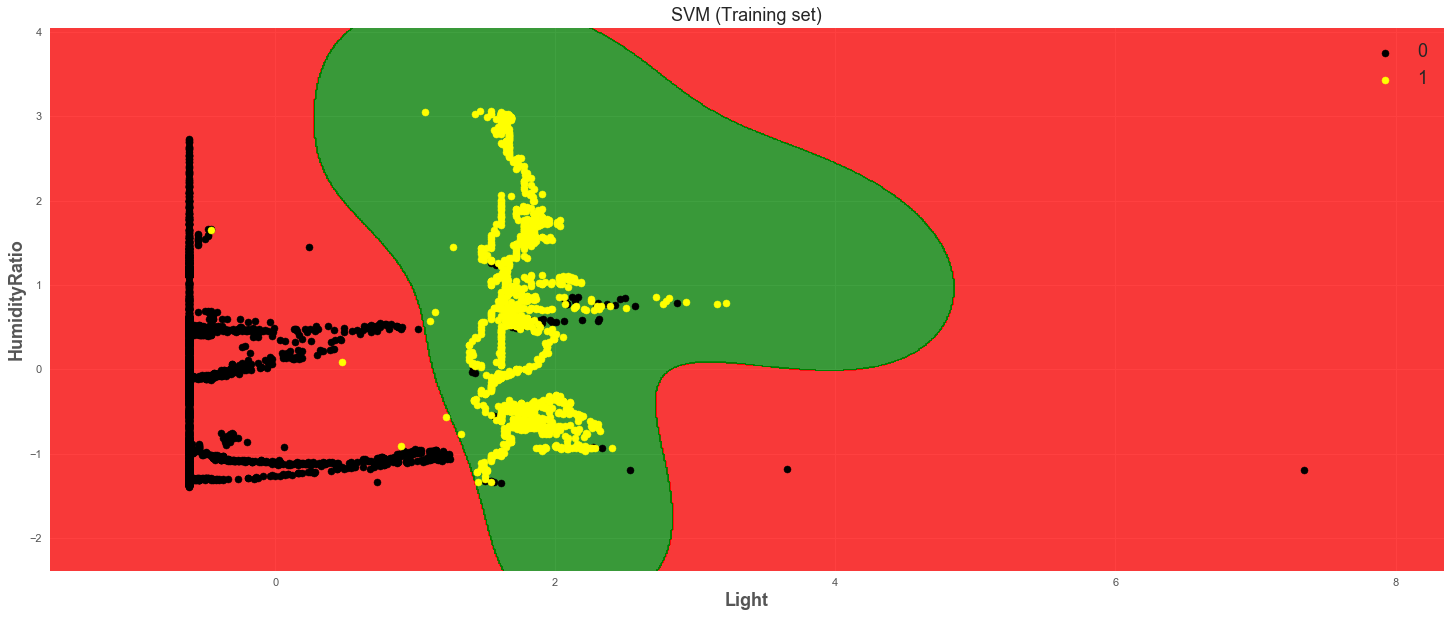

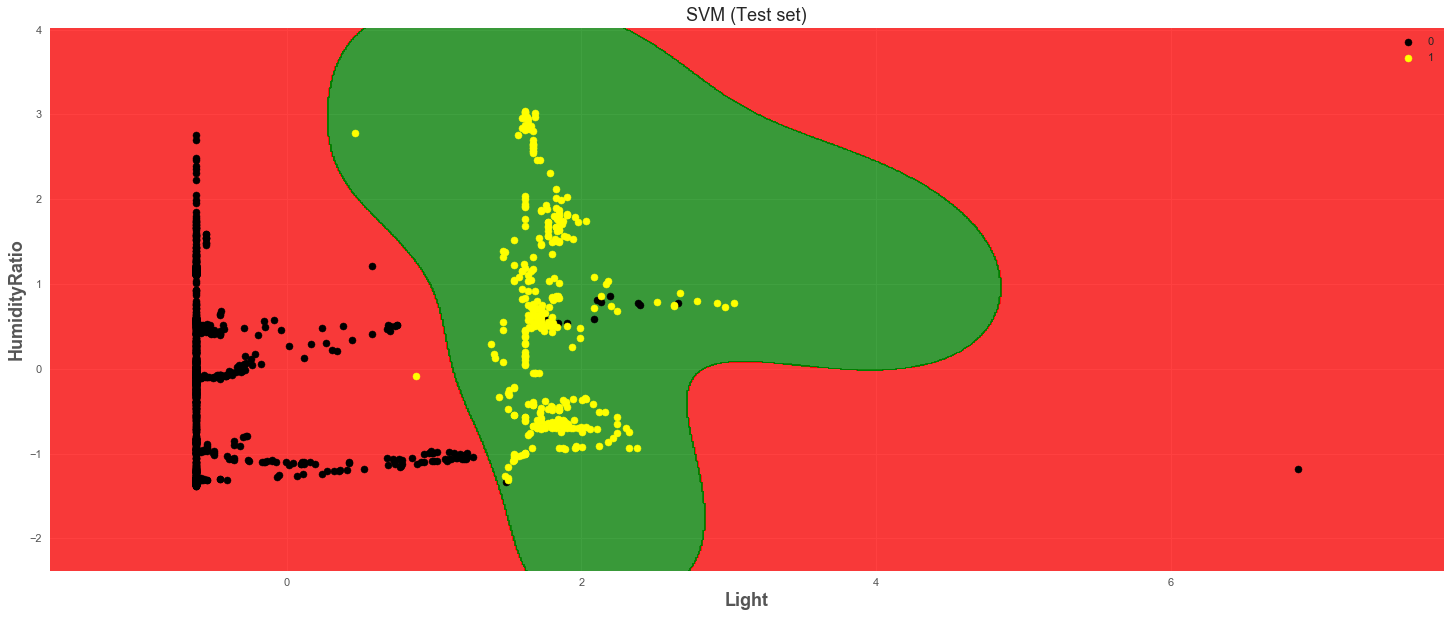

In [505]:
# NonLinear SVM
data = train
inputCol1 = 'Light'
inputCol2 = 'HumidityRatio'
outputCol = 'Occupancy'
kernel = 'rbf'
print "Classfication results using Light and HumidityRatio features with NonLinear SVM(rbf kernel) :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)

Light/HumidityRatio and Light/Humidity models are showing similar results. 

Certainly, light has a fairly good impact on the decision boundary!!!

### CO2 and HumidityRatio

Classfication results using CO2 and HumidityRatio features with Linear SVM :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
83.82

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
95.09


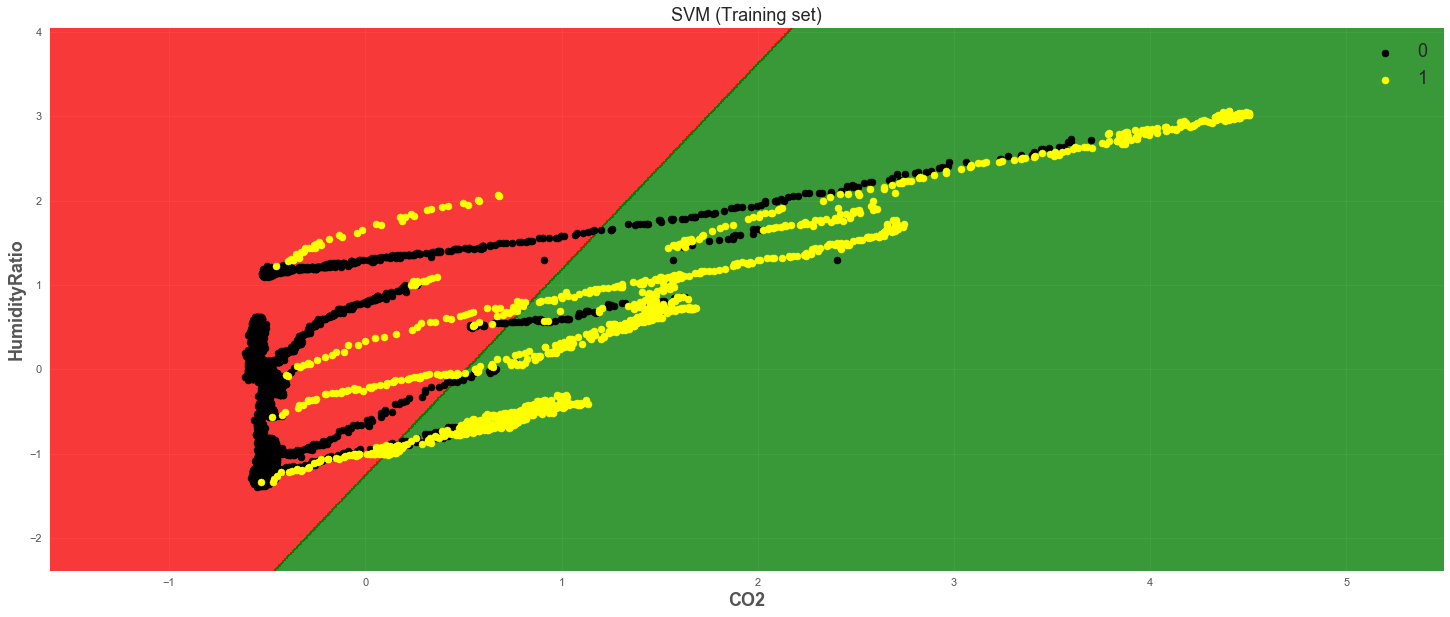

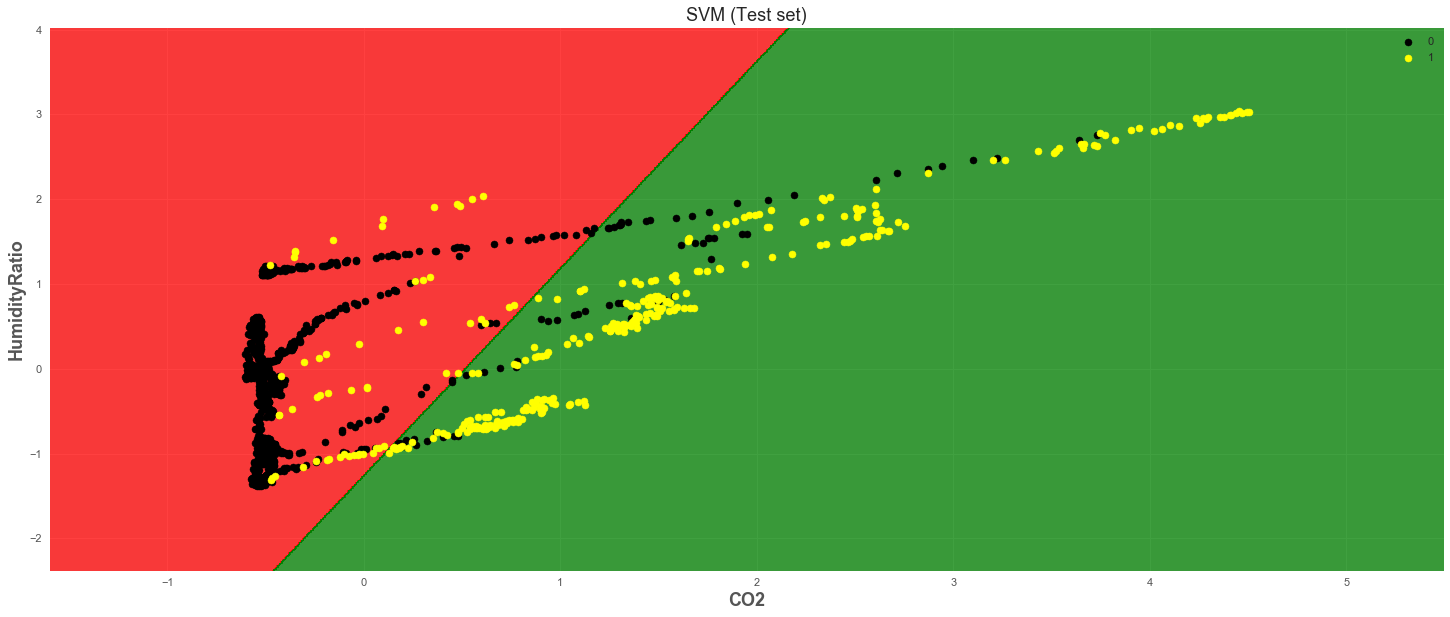

In [506]:
# Linear SVM
data = train
inputCol1 = 'CO2'
inputCol2 = 'HumidityRatio'
outputCol = 'Occupancy'
kernel = 'linear'
print "Classfication results using CO2 and HumidityRatio features with Linear SVM :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)


Classfication results using CO2 and HumidityRatio features with NonLinear SVM(rbf kernel) :

 Sensitivity: Ability of the model to detect occupancy, when the rooms are actually oocupied:
85.84

 Specificity: Ability of the model to rule out occupancy when the rooms are actually unoccupied:
95.64


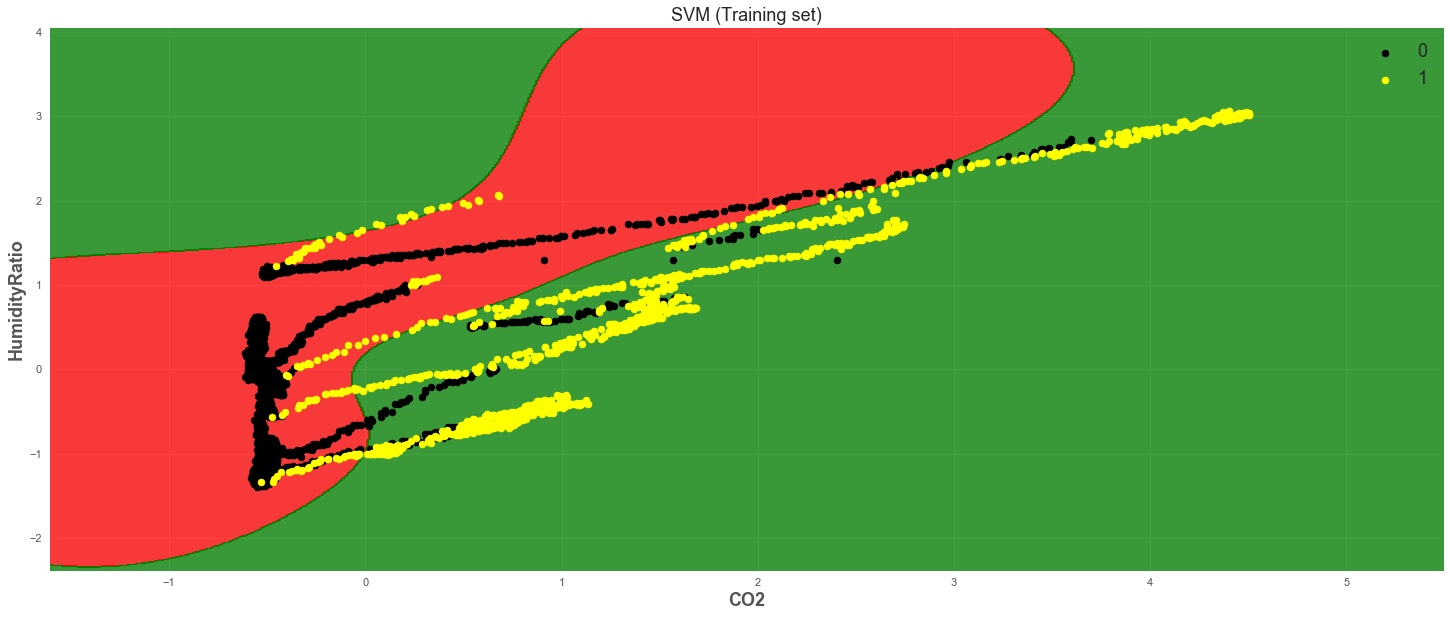

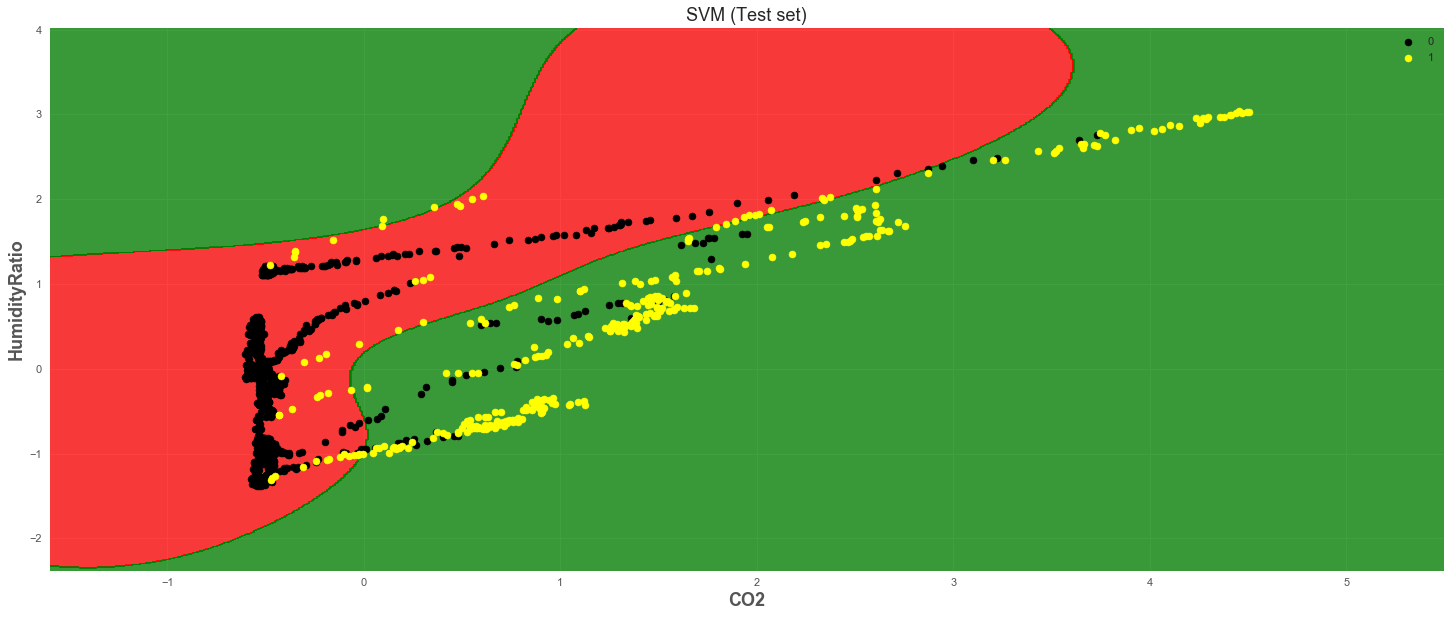

In [507]:
# NonLinear SVM
data = train
inputCol1 = 'CO2'
inputCol2 = 'HumidityRatio'
outputCol = 'Occupancy'
kernel = 'rbf'
print "Classfication results using CO2 and HumidityRatio features with NonLinear SVM(rbf kernel) :"
modelClassifier(data,inputCol1,inputCol2,outputCol,kernel)

CO2 seems to have more impact on the decision boundary. And certainly linear SVM seems to be a wise decision.

From the decision boundaries of the above models, one can confirm that Light has highest predictive power. CO2 comes the second!!


Let's go ahead and apply recursive feature elimination & random forest feature importance techniques to perform feature selection and confirm our intuition.


### Feature Selection through Recursive Feature Elimination

In [407]:
# select the X and y values from training set

X= train[['Temperature','HumidityRatio','Light','CO2']]
y = train['Occupancy']

# Standardize the dataset to be used with linear SVM.
Std = StandardScaler()
X_train = Std.fit_transform(X)
#StratifiedShufflesplit cross validation which preserves the percentge of samples for each class.
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Linear SVM as rbf may lead to poor generalization problems.
model = SVC(kernel='linear')

#Recursive feature elimination with cross validation
selector = RFECV(model,step=1,cv=sss,scoring='recall')
selector.fit(X_train,y)

RFECV(cv=StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None),
   estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=1, scoring='recall', step=1, verbose=0)

In [408]:
# Ranking generated by RFECV
selector.ranking_

array([2, 3, 1, 1])

In [409]:
# Incoporate rankings and feature names in a dataframe and plot the results
features = ['Temperature','HumidityRatio','Light','CO2']
ranking=pd.DataFrame(sorted(zip(selector.ranking_, features), reverse=False))
ranking.columns =['ranking','feature']

In [410]:
ranking

,ranking,feature
0,1,CO2
1,1,Light
2,2,Temperature
3,3,HumidityRatio


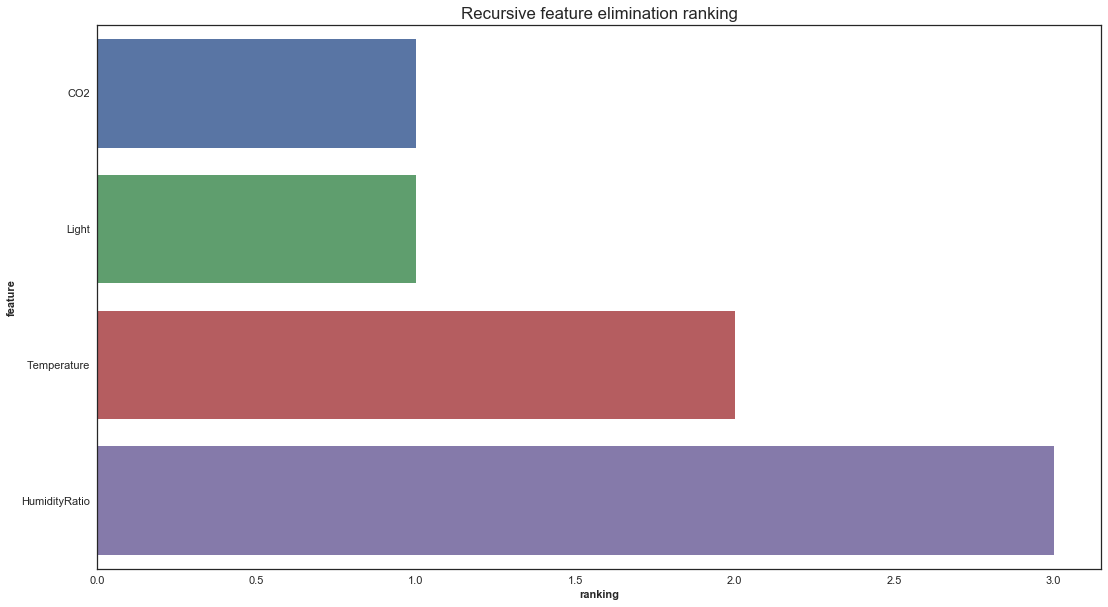

In [411]:
# Plotting the rankings generated by RFECV
sns.set_style('white')
fig, ax = plt.subplots(figsize=(18,10))
sns.set(font_scale=1.4)
sns.barplot(x='ranking',y='feature',data=ranking)
plt.xlabel('ranking')
plt.title("Recursive feature elimination ranking")

Recursive feature elimination technique shows Light and CO2 to have similar and highest predictive power. Temperature comes the second. And HumidityRatio has the least predictive power.

### Feature Selection through Random Forests Feature Importance

In [421]:
from sklearn.ensemble import RandomForestClassifier

# Select X and y training values
X_train = train[['Temperature','Humidity','Light','CO2', 'HumidityRatio']].values
y_train = train['Occupancy'].values

# Standardize the data
Std = StandardScaler()
X_train = Std.fit_transform(X_train)

# Fit the random forest model
RF = RandomForestClassifier()
RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [422]:
# Compute the feature importance
importance=RF.feature_importances_

features = ['Temperature','Humidity','Light','CO2', 'HumidityRatio']

#Incoporate the results in a dataframe and plot the results
temp=pd.DataFrame(sorted(zip(importance, features), reverse=True))
temp.columns =['importance','feature']

In [425]:
temp

,importance,feature
0,0.599957,Light
1,0.261678,CO2
2,0.079377,Temperature
3,0.029632,Humidity
4,0.029355,HumidityRatio


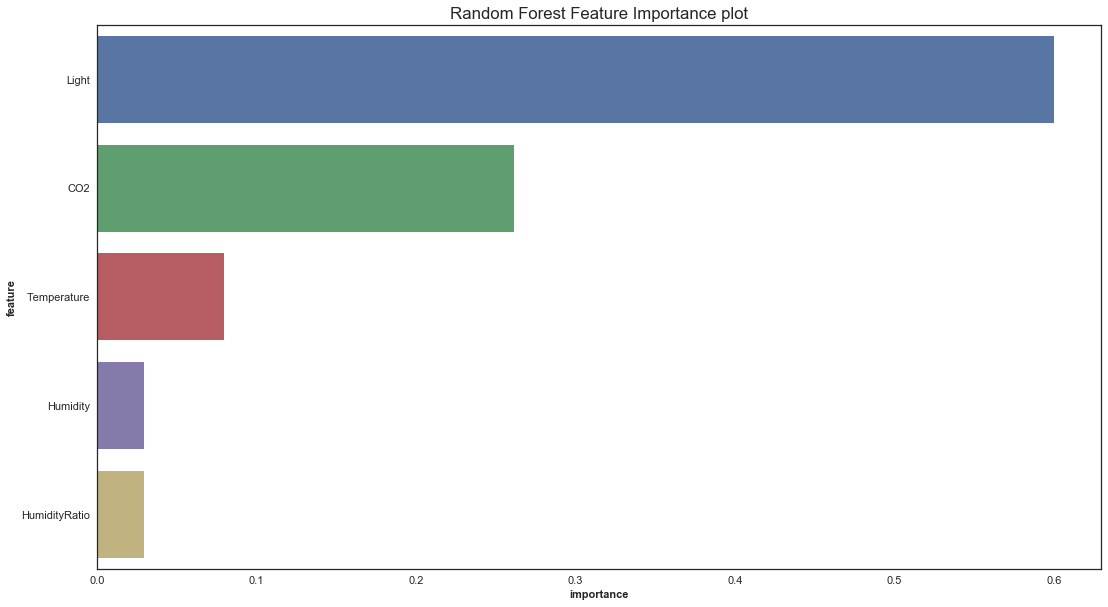

In [426]:
# Plot the features importance generated by random forest
sns.set_style('white')
fig, ax = plt.subplots(figsize=(18,10))
sns.set(font_scale=1.4)
sns.barplot(x='importance',y='feature',data=temp)
plt.xlabel('importance')
plt.title("Random Forest Feature Importance plot")

Besides recursive feature elimination, random forest feature importance measures confirm that Light, CO2 and Temperature are good features for this binary classification task.

So, let's go ahead and use these features....

In [447]:
# Training set
X_train = train[['Temperature','Light','CO2']].values
y_train = train['Occupancy'].values

# Testing set
X_test = test2[['Temperature','Light','CO2']].values
y_test = test2[['Occupancy']].values

# Second Testing set
X_test1 = test[['Temperature','Light','CO2']].values
y_test1 = test['Occupancy'].values

#Pipeline for data standardization and linear SVM classifier
estimator = Pipeline([('Std',StandardScaler()),
                      ('Clf',SVC(kernel='linear'))
                    ])
params = {
    'Clf__C': [0.001,0.01,0.1,1.0,10,100]}


# GridSearchCV to perform exhaustive binary search to find the optimum level of C parameter.
grid = GridSearchCV(estimator, param_grid=params,cv=sss,n_jobs=-1,scoring = 'roc_auc')
grid_result = grid.fit(X_train, y_train)

In [448]:
# summarize results
print("Best model : %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

best_estimator = grid_result.best_estimator_

print best_estimator

Best model : 0.994398 using {'Clf__C': 1.0}
0.993199 (0.001527) with: {'Clf__C': 0.001}
0.994253 (0.001119) with: {'Clf__C': 0.01}
0.994367 (0.001053) with: {'Clf__C': 0.1}
0.994398 (0.001038) with: {'Clf__C': 1.0}
0.994398 (0.001040) with: {'Clf__C': 10}
0.994396 (0.001041) with: {'Clf__C': 100}
Pipeline(steps=[('Std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('Clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


GridSearch results show that the default value of C i.e 1.0 is the best parameter. C represents the penalty parameter for error term(in case of margin violations).

In [446]:
# Helper function for model evaluation
def modelevaluation(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    fpr, tpr, _ =roc_curve(y_test, y_pred, pos_label=1)
    areaUnderCurve = auc(fpr,tpr)
    sensitivity = (1.0*(tp))/(tp+fp)
    specificity = (1.0*(tn))/(tn+fp)
    return (sensitivity, specificity, areaUnderCurve)

In [449]:
# Final model evaluation...
y_preds = best_estimator.predict(X_test)
y_preds1 = best_estimator.predict(X_test1)

print "Model evaluation on testing set 1:"
sensitivity, specificity, areaUnderCurve = modelevaluation(y_test,y_preds)

print "Sensitivity :", sensitivity
print "Specificity :", specificity
print "Area Under ROC Curve :", areaUnderCurve

print "\nModel evaluation on testing set 2:" 
sensitivity1, specificity1, areaUnderCurve1 = modelevaluation(y_test1,y_preds1)

print "Sensitivity :", sensitivity1
print "Specificity :", specificity1
print "Area Under ROC Curve :", areaUnderCurve1


Model evaluation on testing set 1:
Sensitivity : 0.97182425979
Specificity : 0.992340646501
Area Under ROC Curve : 0.992754022616

Model evaluation on testing set 2:
Sensitivity : 0.947214076246
Specificity : 0.968103957472
Area Under ROC Curve : 0.982508768859


### Results and Discussion:

One testing dataset 1 the final model correctly classifies 97.18% of the rooms that are occupied as occupied. Specificity value of 0.9927 indicates that 0.77% of the vacant rooms are incorrectly classified as true positives( as occupied).

One testing dataset 2 the final model correctly classifies 94.72% of the rooms that are occupied as occupied. Specificity value of 0.9681 indicates that 3.19% of the vacant rooms are incorrectly classified as true positives( as occupied).

Area under ROC curve on the both the testing datasets are very high which confirms the goodness of the model.